http://kssc.kostat.go.kr/ksscNew_web/kssc/common/CommonBoardList.do?gubun=1&strCategoryNameCode=019&strBbsId=kascrr&categoryMenu=014

https://geohackweek.github.io/ghw2018_web_portal_inlandwater_co2/InteractiveTimeSeries.html

https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/TimeSliderChoropleth.ipynb

https://www.jumpingrivers.com/blog/interactive-maps-python-covid-19-spread/

# Intro

## Requirements

The following files are required. They should be located in the same directory as the *path* variable

*   '신한은행_경진대회_new.csv',
*   'HangJeongDong_ver20210401.geojson',
*   '서울행정구역분류_20210701.csv'


The following specific python modules must be installed. General modules commonly used in data science are pandas, numpy, matplotlib, os, etc. these should be installed as well. 

*   geopandas
*   folium
*   branca
*   json
*   seaborn
*   datetime



In [ ]:
# Specify working directory 

path='/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/'

In [ ]:
# 한글폰트 사용 in colab

%matplotlib inline  

import matplotlib 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  


!apt-get update -qq
!apt-get install fonts-nanum* -qq

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
matplotlib.rcParams['axes.unicode_minus'] = False

NanumBarunGothic


In [ ]:
import pandas as pd
import numpy as np
import plotly
import datetime
import seaborn as sns

from matplotlib import cm
colors = cm.get_cmap('rainbow')

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install geopandas

In [ ]:
import json
import folium
from folium.plugins import TimeSliderChoropleth
from pandas.io.json import json_normalize

import os
import geopandas as gpd
from branca.colormap import linear
from shapely.geometry import Polygon
from branca.colormap import LinearColormap

# Preprocessing data


The original 신한은행_경진대회.csv file was converted to a standard utf-8 format , since the original was in a euc-kr format. This can be processed easily with excel,

In [ ]:
# Preprocessing data

data=pd.read_csv(path+'신한은행_경진대회_new.csv')
data=data.drop('Unnamed: 0',1)
data['법정동코드'] = data['법정동코드'].map(str)+ "00"
data['집계구코드'] = data['집계구코드'].astype(str)
data['직장인여부'] = data['직장인여부'].astype(str)
data['연령구분'] = data['연령구분'].replace( {1:'10대',
                          2:'20대',
                          3:'30대',
                          4:'40대',
                          5:'50대',
                          6:'60대',
                          7:'60대 초과',
                          })
data['성별'] = data['성별'].replace({1:'남자',
                        2:'여자'})
#times=data['기준년월'].map(str)+ " " +data['주문시간대'].map(str)
data['time'] =  pd.to_datetime(data['기준년월'], format='%Y%m')
data['지역명'] = "서울특별시" + " " + data['지역구'].map(str)+ " " +data['법정동'].map(str)



In [ ]:
data

기준년월  지역구       법정동코드  법정동  ... 주택대출 전세대출       time            지역명
0        201903  강남구  1168010100  역삼동  ...    0    0 2019-03-01  서울특별시 강남구 역삼동
1        201903  강남구  1168010100  역삼동  ...    0    0 2019-03-01  서울특별시 강남구 역삼동
2        201903  강남구  1168010100  역삼동  ...    0    0 2019-03-01  서울특별시 강남구 역삼동
3        201903  강남구  1168010100  역삼동  ...    0    0 2019-03-01  서울특별시 강남구 역삼동
4        201903  강남구  1168010100  역삼동  ...    0    0 2019-03-01  서울특별시 강남구 역삼동
...         ...  ...         ...  ...  ...  ...  ...        ...            ...
1039563  202103  중랑구  1126010600  신내동  ...    0    0 2021-03-01  서울특별시 중랑구 신내동
1039564  202103  중랑구  1126010600  신내동  ...    0    0 2021-03-01  서울특별시 중랑구 신내동
1039565  202103  중랑구  1126010600  신내동  ...    0    0 2021-03-01  서울특별시 중랑구 신내동
1039566  202103  중랑구  1126010600  신내동  ...    0    0 2021-03-01  서울특별시 중랑구 신내동
1039567  202103  중랑구  1126010600  신내동  ...    0    0 2021-03-01  서울특별시 중랑구 신내동

[1039568 rows x 22 columns]

## 0s are not really zeros.

신한은행 데이터는 집계구, 연령, 성별 기준에 속한 신한은행 거래 고객의 각 속성 값들에 대해 outlier제거 후 0 값을 제외한 평균값입니다. 집계구의 연령, 성별 기준으로 속성 값이 0이 아닌 고객 수가 너무 적을 시에는 식별 위험을 방지하기 위해 0값으로 대체했으므로, 0 값을 NaN으로 바꾼다음, 기준년월, 집계구, 연령, 성별 기준 한 평균값들로 대체했습니다.

신용대출 대비 전세대출은 각 집계구, 연령, 성별에 해당하는 고객 수가 적어 0으로 대체된 경우가 많아 수의 차이가 존재합니다. 그래서 NaN들이 여전히 존재합니다.

* **data**: original data data
* **data_nans**: 0 replaced with NaN

* **data_means**: imputed means data

In [ ]:
data_nans = data.replace(0,np.nan)
data_nans

data_means= data_nans.groupby(['기준년월', '집계구코드',	'연령구분',	'성별'] )['급여',	
                                                                             '가맹점매출',	
                                                                             '연금',	
                                                                             '총지출',	
                                                                             '총수신',	
                                                                             '예금,적금',	
                                                                             '신탁',	
                                                                             '수익증권',	
                                                                             '신용대출',	
                                                                             '담보대출',	
                                                                             '주택대출',	
                                                                             '전세대출'	].transform(lambda x: x.fillna(x.mean()))
data_means = pd.concat([data_means, data_nans[['기준년월'	,'time','지역구','지역명'	,'법정동코드',	'법정동',	'집계구코드',	'연령구분',	'성별'	,'직장인여부']] ],axis=1)
data_means

급여         가맹점매출        연금  ...    연령구분  성별  직장인여부
0                 NaN           NaN       NaN  ...     20대  남자      0
1        2.024443e+06           NaN       NaN  ...     20대  여자      0
2        3.458901e+06           NaN       NaN  ...     30대  남자      0
3        3.225594e+06           NaN       NaN  ...     30대  여자      0
4        5.195709e+06  1.920496e+07       NaN  ...     40대  남자      0
...               ...           ...       ...  ...     ...  ..    ...
1039563  2.625483e+06  3.744806e+06       NaN  ...     50대  여자      0
1039564  2.541418e+06  2.846798e+06  738450.0  ...     60대  남자      0
1039565  1.232367e+06  1.964941e+06  595480.0  ...     60대  여자      0
1039566  4.898128e+05           NaN  409938.0  ...  60대 초과  남자      0
1039567  4.225548e+05           NaN  322286.0  ...  60대 초과  여자      0

[1039568 rows x 22 columns]

In [ ]:
"""
'HangJeongDong_ver20210401.geojson' contains the necessary polygon shapes of 법정동, which uses 법정동코드 as the identifer. 
We can map the polygon shapes by 법정동 to our data by merging on 법정동. However, I found that 법정동 is sometimes unreliable as an identifer, 
and using 행정구역코드 is generally better. 

In our data 법정동코드 is the unique identifier.
However, the Geojson file 'HangJeongDong_ver20210401.geojson' is uses 행정구역코드 as the unique identifer. 
Fortunately, 서울행정구역분류_20210701.csv data contains the necessary 법정동코드 and 행정구역코드. 
We will use functions to merge by the common identifers, then calculate the mean of each column in the data when grouped by 행정구역(법정동)
"""

행정구역 = pd.read_csv(path+'서울행정구역분류_20210701.csv')
행정구역 = 행정구역.apply(pd.to_numeric , errors='ignore')
행정구역['법정동코드'] = 행정구역['법정동코드'].astype(int)
행정구역['행정구역코드'] = 행정구역['행정구역코드'].astype(int)

In [ ]:
행정구역

시도    시군구  행정구역명  ...       법정동코드 법정동 관할지역              행정동 영문명칭
0    서울특별시  서울특별시  서울특별시  ...  1100000000      NaN                 Seoul
1    서울특별시    종로구    종로구  ...  1111000000      NaN             Jongno-gu
2    서울특별시    종로구  청운효자동  ...  1111010100      NaN    Cheongunhyoja-dong
3    서울특별시    종로구  청운효자동  ...  1111010200      NaN    Cheongunhyoja-dong
4    서울특별시    종로구  청운효자동  ...  1111010300      NaN    Cheongunhyoja-dong
..     ...    ...    ...  ...         ...      ...                   ...
762  서울특별시    강동구   성내2동  ...  1174010800     분할연계    Seongnae 2(i)-dong
763  서울특별시    강동구   성내3동  ...  1174010800     분할연계  Seongnae 3(sam)-dong
764  서울특별시    강동구     길동  ...  1174010500      NaN              Gil-dong
765  서울특별시    강동구   둔촌1동  ...  1174010600     분할연계    Dunchon 1(il)-dong
766  서울특별시    강동구   둔촌2동  ...  1174010600     분할연계     Dunchon 2(i)-dong

[767 rows x 11 columns]

## Functions: *mean_groupby_dong* and *map_data_preprocessing*

In [ ]:
# making mean data and map data

def mean_groupby_dong(path, data): 
  """
Requirements: 
1. '서울행정구역분류_20210701.csv'
2. preprocessed data

Input: directory as path, preprocessed data
Output: dongmean
  """
  ## c= data.merge(행정구역[['법정동코드','행정구역코드','행정동(행정기관명)']].drop_duplicates(subset='법정동코드', keep='first'), on='법정동코드')
  행정구역 = pd.read_csv(path+'서울행정구역분류_20210701.csv')
  행정구역 = 행정구역.apply(pd.to_numeric , errors='ignore')
  행정구역['법정동코드'] = 행정구역['법정동코드'].astype(int)
  행정구역['행정구역코드'] = 행정구역['행정구역코드'].astype(int)
  data['법정동코드'] = data['법정동코드'].astype(int)
  map_data=  data.merge(행정구역[['법정동코드','행정구역코드', '행정동(행정기관명)']], on='법정동코드')
  dongmean = map_data.groupby(['기준년월', 'time' ,'행정구역코드']).mean().reset_index() # group by location and time and make mean data : dongmean
  dongmean['행정구역코드']=dongmean['행정구역코드'].astype(str)
  return dongmean



def map_data_preprocessing(path, dongmean):
  """
Requirements: 
1. 'HangJeongDong_ver20210401.geojson'
2. dongmean, or the output of the mean_groupby_dong() function.

Input: directory as path, dongmean
Output: 행정구역_gdf
# 
Use geopandas to load a dataset containing the dong_shape
  """
  # use geopandas to make geopandas df
  dong_shape = gpd.read_file(path+'HangJeongDong_ver20210401.geojson')
  dong_shape['행정구역코드'] = dong_shape['adm_cd']
  # merge on 행정구역
  dongmean_polygon = dongmean.merge(dong_shape[['geometry','행정구역코드']], on='행정구역코드') # dongmean_polygon
  # Take the polygons of the merged data and make into GeoDataFrame. The 행정구역_gdf index matches that of dongmean
  행정구역_df = dongmean_polygon[['geometry']]
  행정구역_gdf = gpd.GeoDataFrame(행정구역_df)
  행정구역_gdf = 행정구역_gdf.drop_duplicates().reset_index() # 행정구역_gdf
  return 행정구역_gdf, dongmean_polygon

# Output of Functions


* Processed datasets used for creating maps: **dongmean_map, 행정구역_gdf, dongmean_polygon.**

* Processed datasets used for creating graphs: **dongmean_graph**

In [ ]:
# Execute function

dongmean_map = mean_groupby_dong(path, data)
dongmean_graph = mean_groupby_dong(path, data_means)
행정구역_gdf, dongmean_polygon = map_data_preprocessing(path, dongmean_map)

In [ ]:
special = data[(data['집계구코드']=='1100000000000.0') | (data['집계구코드']== '1110000000000.0')| (data['집계구코드']=='1120000000000.0') |(data['집계구코드']=='1130000000000.0') ]
special.to_csv(path+'special.csv')

# Visualizing with plots

## Simple plots

For monetary features such as 급여, 가맹점매출, 연금, etc, the data is highly skewed. 
Since there are lots of zeros in the original data, using the *data_means* dataset would be more appropriate for graphing

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8ff984b10>,
      dtype=object)

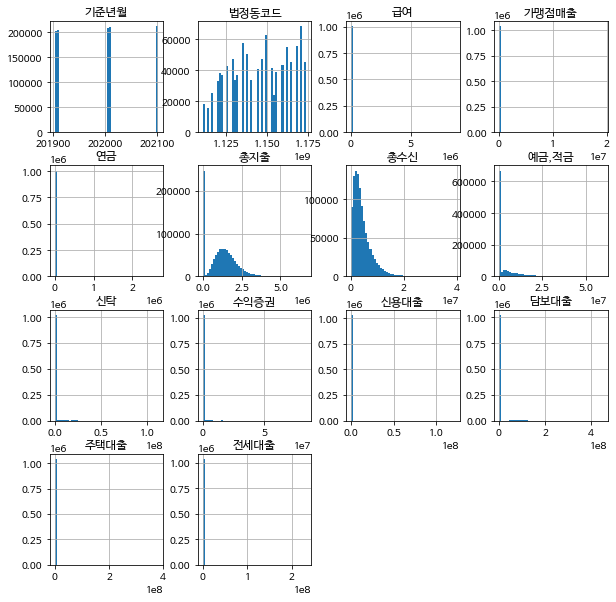

In [ ]:
data.hist(figsize=(10,10), bins=50)

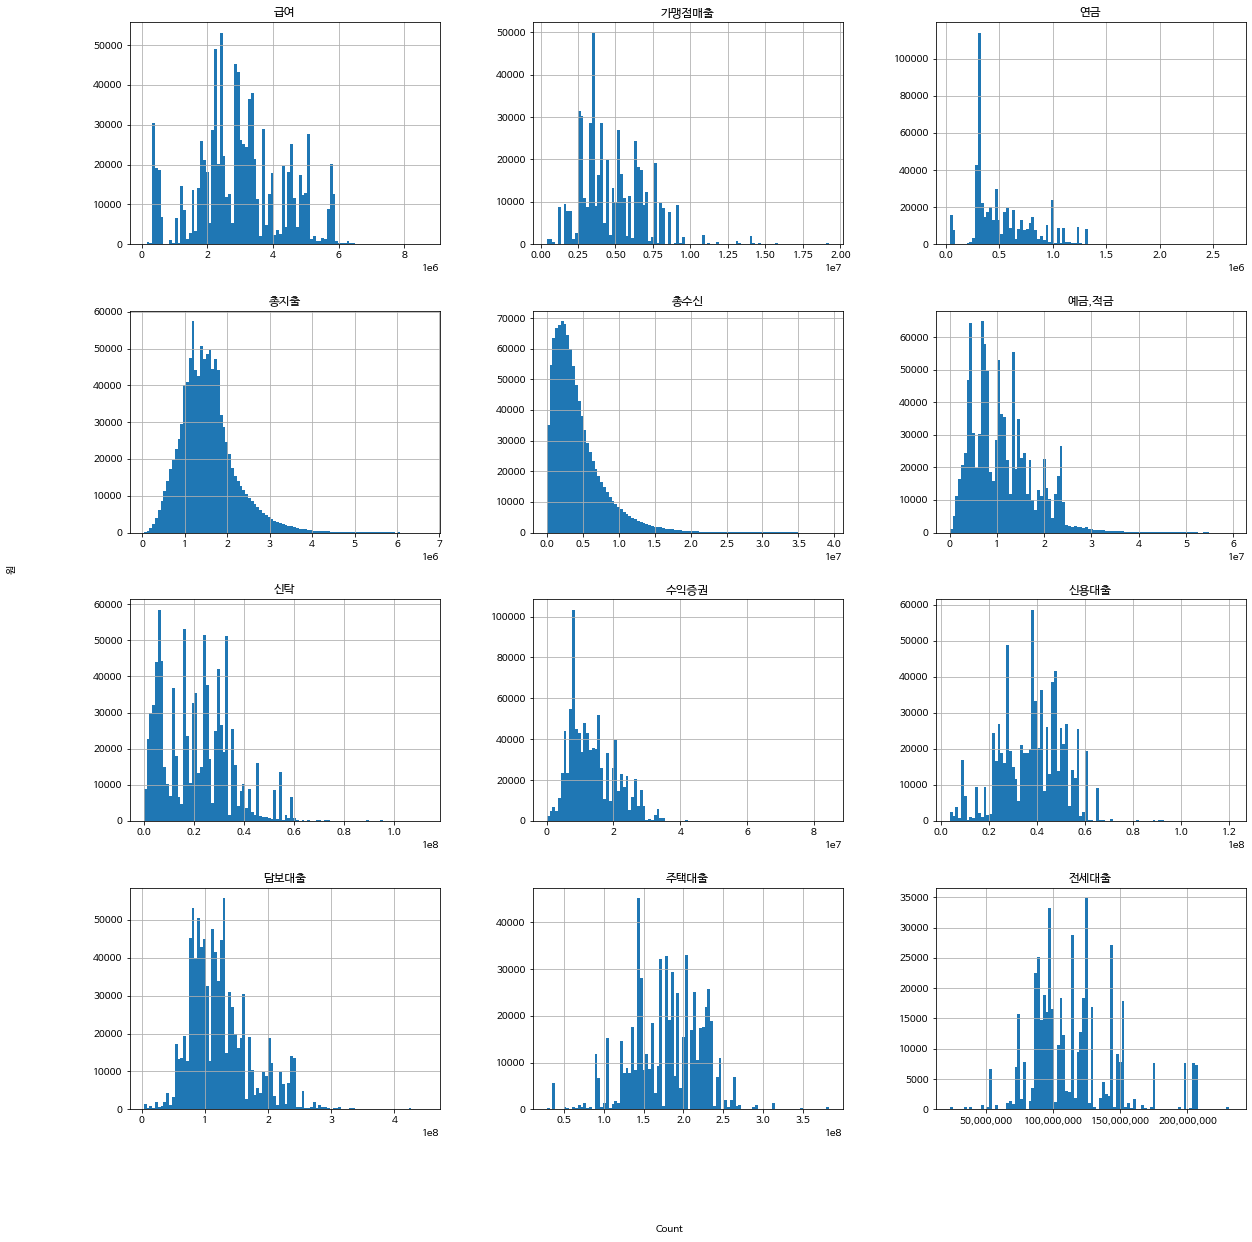

In [ ]:
num_features=['급여',	'가맹점매출',	'연금',	'총지출',	'총수신',	'예금,적금'	,'신탁',	'수익증권'	,'신용대출',	'담보대출',	'주택대출',	'전세대출']
fig, axes = plt.subplots(figsize=(20,20), nrows=4, ncols=3, sharex=False, sharey=False)

data_means[num_features].hist(bins=100, ax=axes)
ax=plt.gca()

ax.get_xaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
fig.text(0.5, 0.04, 'Count', ha='center')
fig.text(0.04, 0.5, '원', va='center', rotation='vertical')
plt.show()

## Counts of categorical features 

Categorical features such as 법정동코드, 연령구분, 성별, 직장인 여부, 집계구코드 are shown here. 

The majority of the data have the following 집계구코드 
* 1120000000000.0 
* 1110000000000.0   
* 1100000000000.0     
* 1130000000000.0

The majority of the data are under 직장인. The data seems pretty even for 성별.


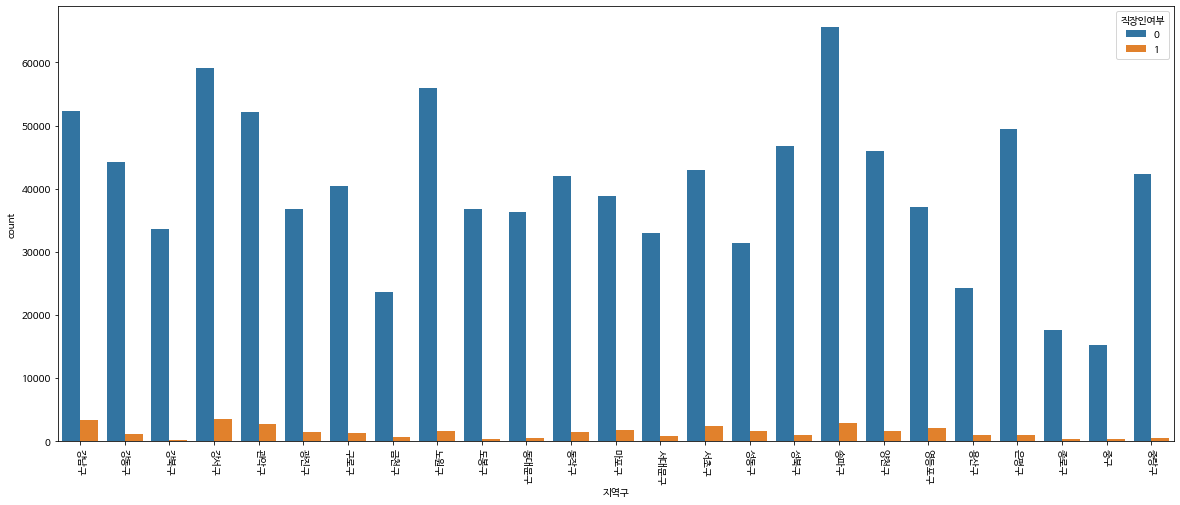

In [ ]:
plt.figure(figsize=(20,8))
sns.countplot(x='지역구',  data=data,  hue='직장인여부')
plt.xticks(rotation=-90)
plt.show()

<Figure size 1440x576 with 0 Axes>

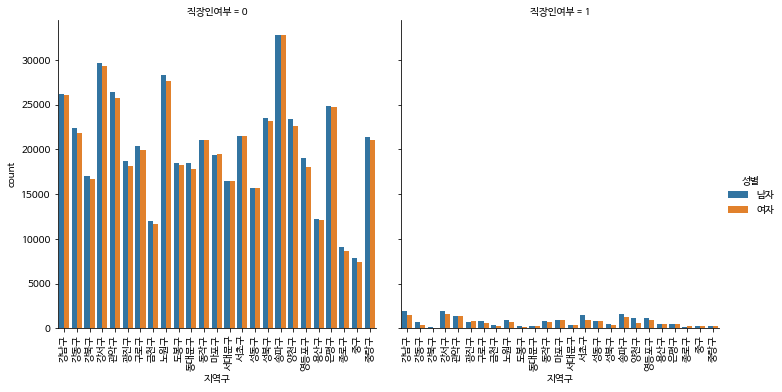

In [ ]:
plt.figure(figsize=(20,8))
g = sns.catplot(x="지역구", hue='성별', col='직장인여부',
                data=data, kind="count")
g.set_xticklabels(rotation=90)
plt.show()

## Counts of each category are shown here

In [ ]:
cat_features=['기준년월','지역구', '법정동코드', '법정동','집계구코드', '연령구분', '성별', '직장인여부']

for col in cat_features: 
    try:      
        print("---- %s ---" % col)
        print(data[col].value_counts(dropna=False))
        print("\n")
    except ValueError:
        print('This column can not be represented. Check datatype')

---- 기준년월 ---
202103    211886
202009    210307
202003    208936
201909    204949
201903    203490
Name: 기준년월, dtype: int64


---- 지역구 ---
송파구     68405
강서구     62611
노원구     57599
강남구     55601
관악구     54845
은평구     50430
성북구     47630
양천구     47630
서초구     45404
강동구     45341
동작구     43572
중랑구     42952
구로구     41700
마포구     40649
영등포구    39104
광진구     38192
도봉구     37119
동대문구    36774
강북구     33833
서대문구    33733
성동구     33053
용산구     25326
금천구     24284
종로구     18127
중구      15654
Name: 지역구, dtype: int64


---- 법정동코드 ---
1162010200    27423
1162010100    25258
1150010300    24449
1135010500    23231
1147010100    18652
              ...  
1111015100        7
1111013800        5
1150011100        3
1114010600        1
1114012300        1
Name: 법정동코드, Length: 453, dtype: int64


---- 법정동 ---
신림동       27423
봉천동       25258
화곡동       24449
상계동       23231
신정동       18851
          ...  
묘동            7
종로2가          5
과해동           3
회현동3가         1
남대문로1가        1
Name: 법정동, Length: 4

## Correlation plot of the data

Since most of the data has zero, the imputed means *data_means* data was used to make correlation plot.

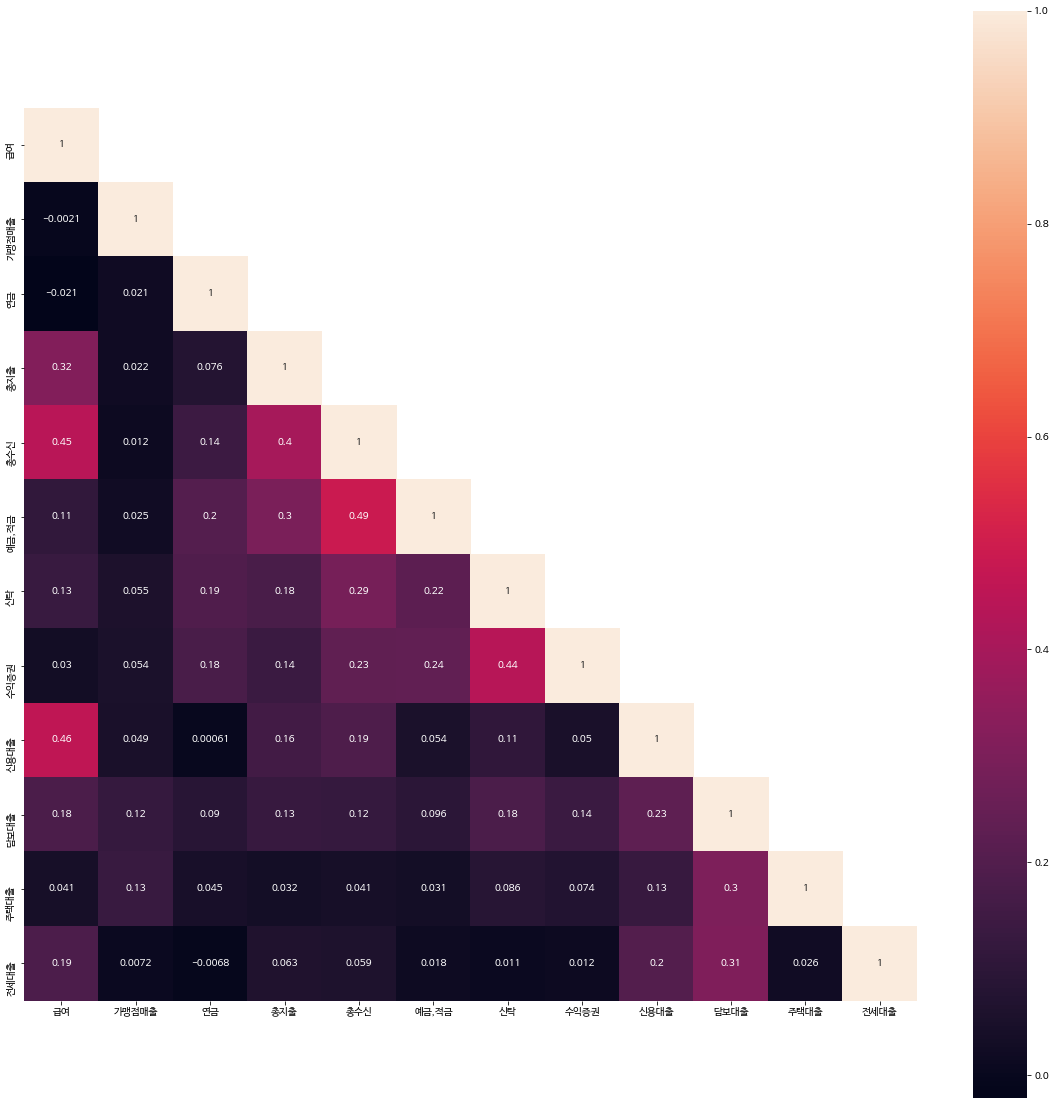

In [ ]:
num_features=['급여','가맹점매출','연금',	'총지출',	'총수신',	'예금,적금'	,'신탁',	'수익증권'	,'신용대출',	'담보대출',	'주택대출',	'전세대출']

corrmat = data_nans[num_features].corr()
mask = np.array(corrmat)
mask[np.tril_indices_from(mask)]=False
plt.subplots(figsize=(20,20))
sns.heatmap(corrmat, mask=mask, annot = True, square=True)

c = corrmat.abs()

s = c.unstack()
so = s.sort_values(ascending=True).drop_duplicates()

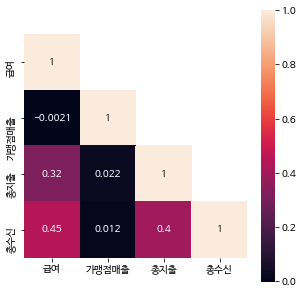

In [ ]:
num_features=['급여','가맹점매출','총지출',	'총수신']

corrmat = data[num_features].corr()
mask = np.array(corrmat)
mask[np.tril_indices_from(mask)]=False
plt.subplots(figsize=(5,5))
sns.heatmap(corrmat, mask=mask, annot = True, square=True)

c = corrmat.abs()

s = c.unstack()
so = s.sort_values(ascending=True).drop_duplicates()

## Scatterplot of 수신, 지출, 급여 & 가맹점매출

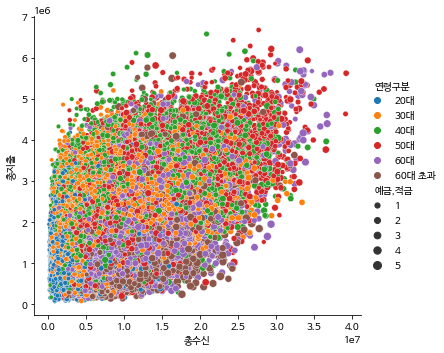

<Figure size 1080x576 with 0 Axes>

In [ ]:
ax=sns.relplot(x = '총수신', y= '총지출', hue = '연령구분', size = '예금,적금', sizes=(), data=data_nans)
plt.figure(figsize = (15,8))
plt.show()

<Figure size 1080x576 with 0 Axes>

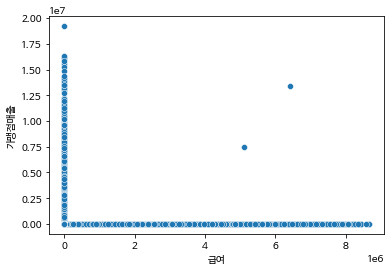

<Figure size 1080x576 with 0 Axes>

In [ ]:
ax=sns.scatterplot(x = '급여', y= '가맹점매출', data=data)
plt.figure(figsize = (15,8))

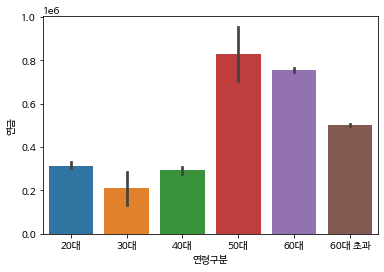

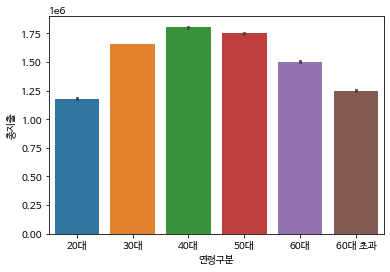

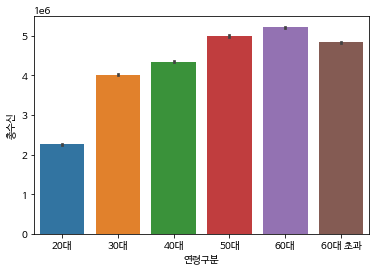

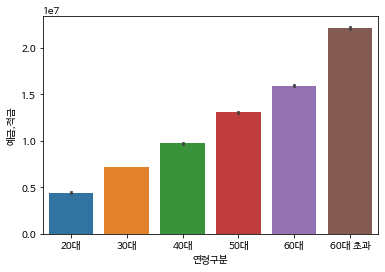

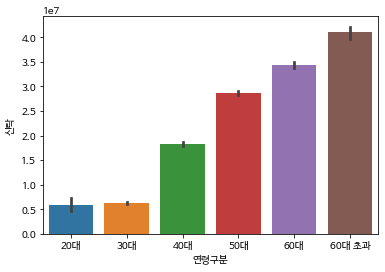

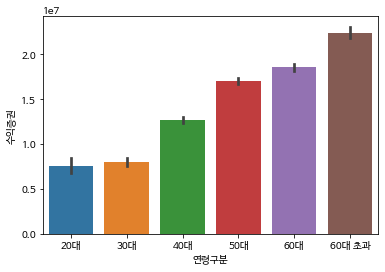

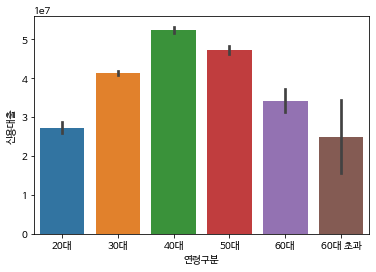

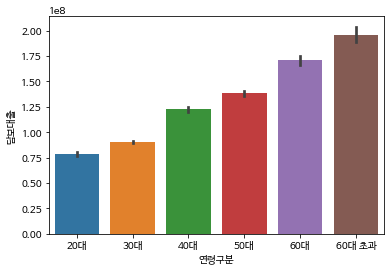

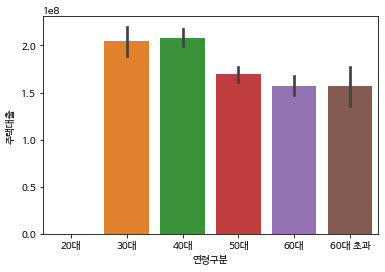

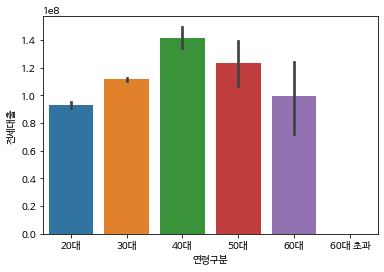

In [ ]:
num_features=['연금',	'총지출',	'총수신',	'예금,적금'	,'신탁',	'수익증권'	,'신용대출',	'담보대출',	'주택대출',	'전세대출']
for i in num_features:
  sns.barplot(x = '연령구분', y= i ,data=data_nans)
  plt.show()




In [ ]:
!wget -O "/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/HangJeongDong_ver20210401.geojson" https://github.com/vuski/admdongkor/raw/master/ver20210401/HangJeongDong_ver20210401.geojson

# Discussion of graph data

To show the change in Total 지출 per time period, a heatmap was created. Positive changes are denoted in green color while negative changes are in red. 

As an example, 2020-03 was the period of greatest decrease. This sharp 지출 decrease is a phenomenon universally seen across all categories ('연령구분', '지역구', '직장인여부') and seoul locations, and can be seen easily by the distinguished red colored tiles on 2020-03. 

On 2020-12-08, Korea announced stricter quarantine rules due to the third wave resurgence of COVID cases. The raised standards of 2.5 단계 involved restrictions on gathering of at least 10 people. Many businesses in all seoul areas were heavily effected by this new restriction, so 지출 decreased.

Afterwards by 2021-03, most categories of total 지출 rebounced and experienced a sharp increase of 지출. 

60대 초과 나이대 people were affected the most by the COVID situation. 



# Discussion of Map data

Spatial data is shown in the html folium map files produced in every folder. In terms of 총지출 , for example, each file *plot_dongmean총지출_YYYYMM.html* in the folder shows the map data of that particular time period. 

Since 동 is more precise than 구, I skipped 구 for some data columns.

Rather than one html file per year, I have created a function which displays the temporospatial data in one html file. This is shown later in the section **Time Slider Functions **.

## 평균 지출

### Data plots over time

There are too many 집계구코드 and 법정동, so it is better to display time in a temporal spacial map, rather than all in one graph.



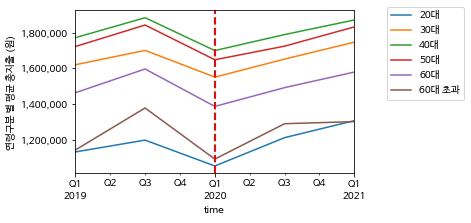

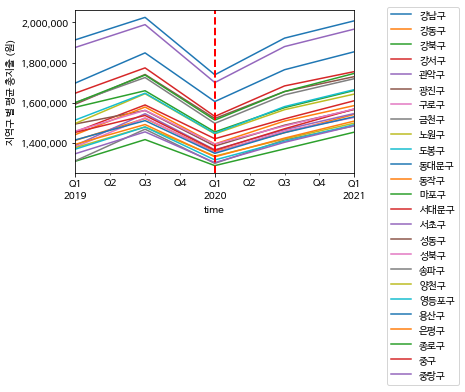

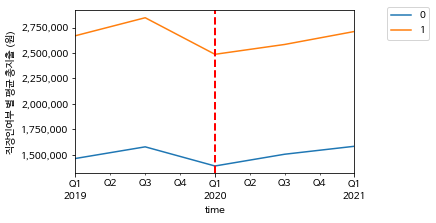

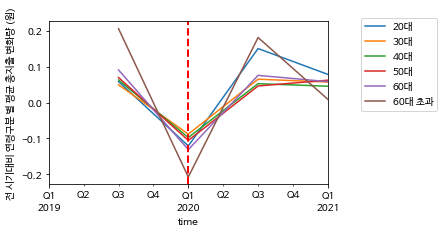

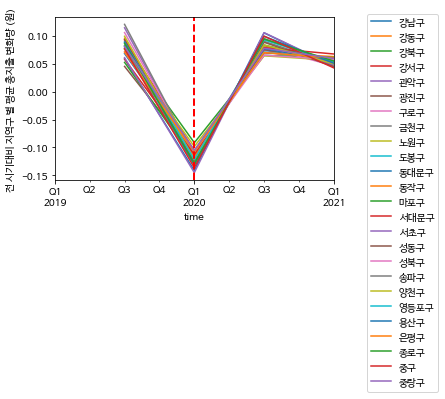

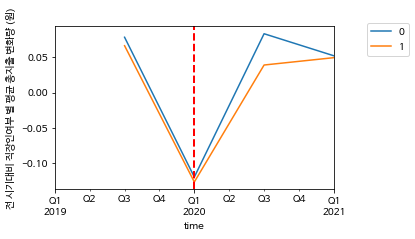

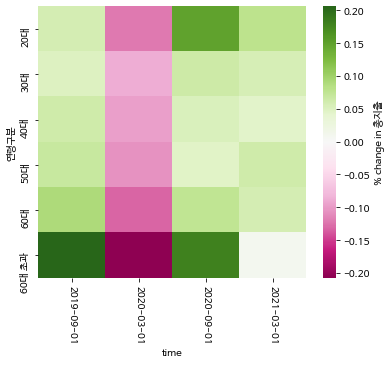

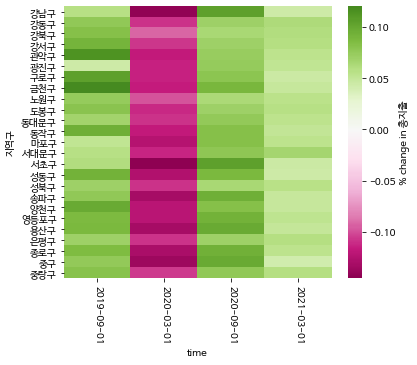

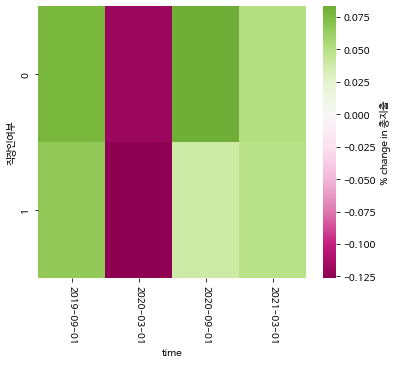

In [ ]:
list_of_categories = ['연령구분', '지역구', '직장인여부']
for cat in list_of_categories:
  data_detail_type = data_means.groupby(['time',cat])['총지출'].agg('mean')
  ax1 = data_detail_type.unstack(cat, fill_value=0).plot(figsize=(5,3)).set_ylabel('{0} 별 평균 총지출 (원)'.format(cat))
  plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
  ax=plt.gca()
  ax.get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
  plt.legend(bbox_to_anchor=(1.1, 1.05))

for cat in list_of_categories:
  data_detail_type = data_means.groupby(['time',cat])['총지출'].agg('mean').groupby([cat]).pct_change()
  ax1 = data_detail_type.unstack(cat, fill_value=0).plot(figsize=(5,3)).set_ylabel('전 시기대비 {0} 별 평균 총지출 변화량 (원)'.format(cat))
  plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
  plt.legend(bbox_to_anchor=(1.1, 1.05))

for cat in list_of_categories:
  d = data_means.groupby(['time',cat])['총지출'].agg('mean').groupby([cat]).pct_change()

  df = pd.DataFrame(d).reset_index().pivot_table(index=cat, columns="time", values='총지출')

  f, axes = plt.subplots(1, 1, figsize=(6,5))
  ax = sns.heatmap(df, cbar_kws={'label': '% change in 총지출'}, cmap="PiYG",center=0)

  ax.set_xticklabels(df.iloc[0].index.strftime('%Y-%m-%d'))
  plt.xticks(rotation=-90)

  plt.show()

In [ ]:
# data_dong_type = data_means.groupby(['time','법정동'])['총지출'].agg('mean')
# ax3 = data_dong_type.unstack('법정동', fill_value=0).plot(figsize=(15,8), cmap=colors).set_ylabel('법정동 별 총 총지출 (원)')
# plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
# plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=5)

# data_age_type = data_means.groupby(['time','집계구코드'])['총지출'].agg('mean')
# ax4 = data_age_type.unstack('집계구코드', fill_value=0).plot(figsize=(15,8)).set_ylabel('집계구코드 별 총 총지출 (원)')
# plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
# plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=5)

### 지도로 시각화하기 위한 데이터 processing

시기별로 구/동 별로 평균한 개인 총 지출 급여를 계산하여, dictionary 로 저장

In [ ]:
times= [201903, 201909, 202003, 202009, 202103]

appended_data_dong={}
for i, year in enumerate(times):
  dongmean총지출=map_data[map_data['기준년월']==year ].groupby('행정구역코드')['총지출'].mean().reset_index()
  dongmean총지출['행정구역코드']=dongmean총지출['행정구역코드'].astype(str)
  appended_data_dong[year] = dongmean총지출

appended_data_gu={}
for i, year in enumerate(times):
  gumean총지출=data[data['기준년월']==year ].groupby('지역구')['총지출'].mean().reset_index()
  gumean총지출['지역구']=gumean총지출['지역구'].astype(str)
  appended_data_gu[year] = gumean총지출

### 구를 기준으로 평균 지출를 지도로 시각화

In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/skorea-municipalities-2018-geo.json'
geo_str = json.load(open(geo_path ,encoding='utf-8'))


directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/gumean총지출/'

if not os.path.exists(directory):
  os.makedirs(directory)

for year, yearlydata in appended_data_gu.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('지역구', '총지출'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='구 평균 총지출',
                nan_fill_color = "White",
                threshold_scale=[0, 500000, 1000000, 1500000, 2000000, 2500000],
                key_on='properties.name').add_to(map)
  folium.LayerControl().add_to(map)
  map.save(directory+'plot_gumean총지출_{0}.html'.format(year))

  #display(map)


### 동를 기준으로 평균 지출를 지도로 시각화

In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/HangJeongDong_ver20210401.geojson'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/dongmean총지출/'

if not os.path.exists(directory):
  os.makedirs(directory)


for year, yearlydata in appended_data_dong.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('행정구역코드', '총지출'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='동별 평균 총지출',
                nan_fill_color = "White",
                threshold_scale=[0, 500000, 1000000, 1500000, 2000000, 2500000],
                key_on='feature.properties.adm_cd').add_to(map)
  folium.LayerControl().add_to(map)

  map.save(directory+'plot_dongmean총지출_{0}.html'.format(year))

  #display(map)

## 평균 수신

### 동를 기준으로 평균 수신를 지도로 시각화

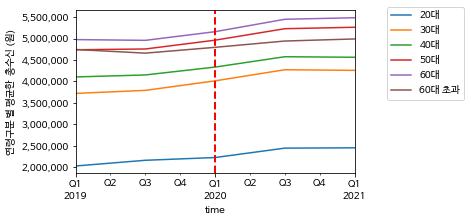

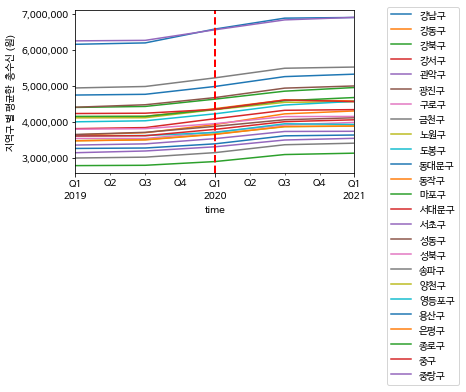

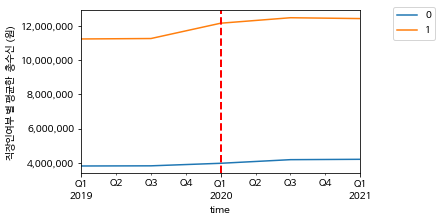

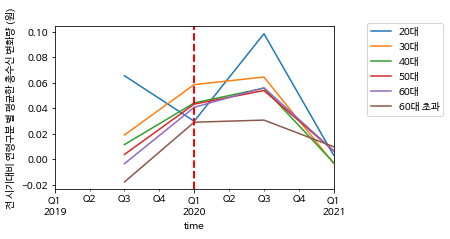

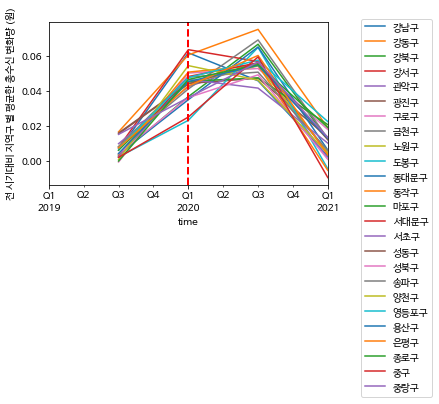

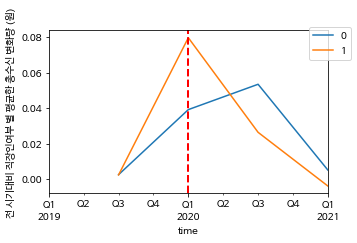

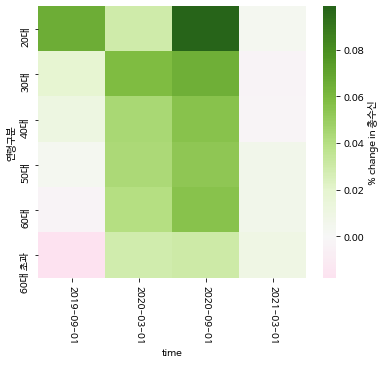

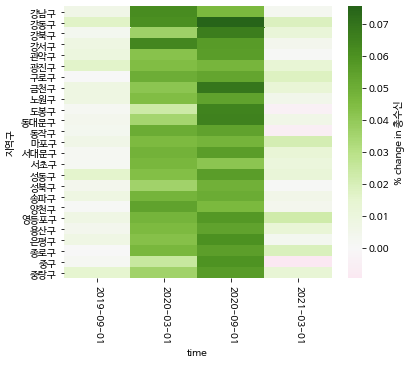

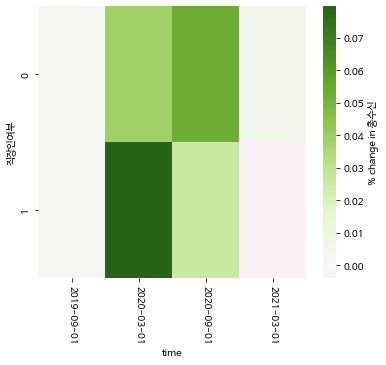

In [ ]:
list_of_categories = ['연령구분', '지역구', '직장인여부']
for cat in list_of_categories:
  data_detail_type = data_means.groupby(['time',cat])['총수신'].agg('mean')
  ax1 = data_detail_type.unstack(cat, fill_value=0).plot(figsize=(5,3)).set_ylabel('{0} 별 평균한  총수신 (원)'.format(cat))
  plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
  ax=plt.gca()
  ax.get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
  plt.legend(bbox_to_anchor=(1.1, 1.05))

for cat in list_of_categories:
  data_detail_type = data_means.groupby(['time',cat])['총수신'].agg('mean').groupby([cat]).pct_change()
  ax1 = data_detail_type.unstack(cat, fill_value=0).plot(figsize=(5,3)).set_ylabel('전 시기대비 {0} 별 평균한 총수신 변화량 (원)'.format(cat))
  plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
  plt.legend(bbox_to_anchor=(1.1, 1.05))

for cat in list_of_categories:
  d = data_means.groupby(['time',cat])['총수신'].agg('mean').groupby([cat]).pct_change()

  df = pd.DataFrame(d).reset_index().pivot_table(index=cat, columns="time", values='총수신')

  f, axes = plt.subplots(1, 1, figsize=(6,5))
  ax = sns.heatmap(df, cbar_kws={'label': '% change in 총수신'}, cmap="PiYG",center=0)

  ax.set_xticklabels(df.iloc[0].index.strftime('%Y-%m-%d'))
  plt.xticks(rotation=-90)

  plt.show()

In [ ]:
times= [201903, 201909, 202003, 202009, 202103]

appended_data_dong={}
for i, year in enumerate(times):
  dongmean총수신=c[c['기준년월']==year ].groupby('행정구역코드')['총수신'].mean().reset_index()
  dongmean총수신['행정구역코드']=dongmean총수신['행정구역코드'].astype(str)
  appended_data_dong[year] =   dongmean총수신


In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/HangJeongDong_ver20210401.geojson'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/dongmean총수신/'

if not os.path.exists(directory):
  os.makedirs(directory)


for year, yearlydata in appended_data_dong.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('행정구역코드', '총수신'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='동별 평균 총수신',
                nan_fill_color = "White",
                #threshold_scale=[0, 500000, 1000000, 1500000, 2000000, 2500000],
                key_on='feature.properties.adm_cd').add_to(map)
  folium.LayerControl().add_to(map)

  map.save(directory+'plot_dongmean총수신_{0}.html'.format(year))

## 평균 급여
### 지도로 시각화하기 위한 데이터 processing

시기별로 구/동 별로 평균 급여를 계산하여, dictionary 로 저장

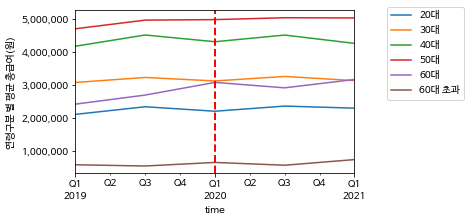

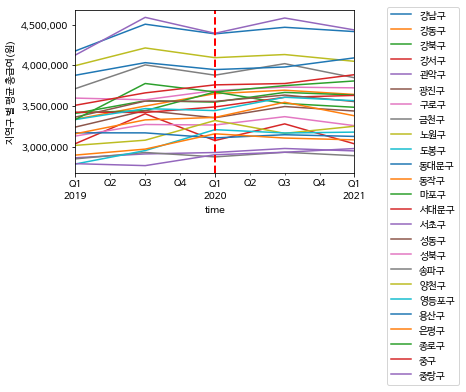

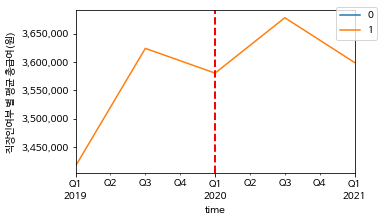

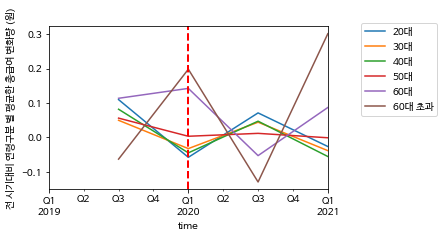

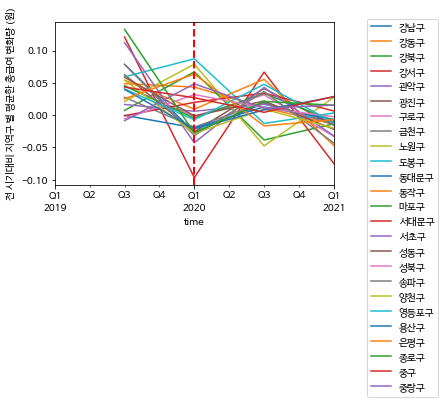

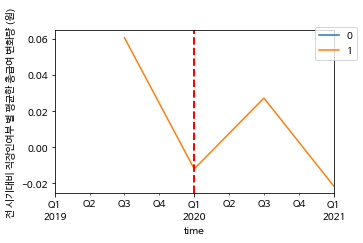

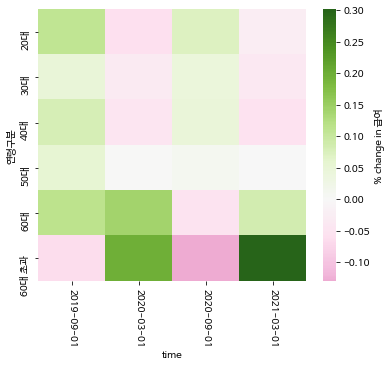

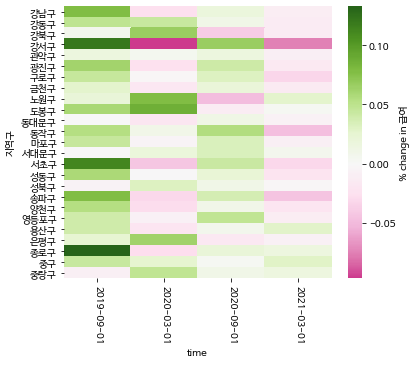

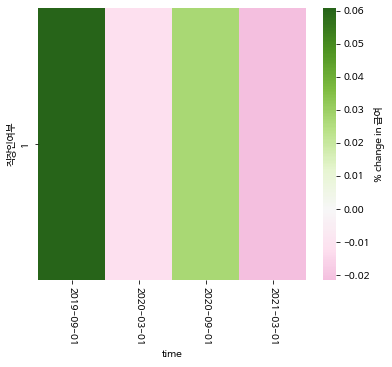

In [ ]:
list_of_categories = ['연령구분', '지역구', '직장인여부']
for cat in list_of_categories:
  data_detail_type = data_nans.groupby(['time',cat])['급여'].agg('mean')
  ax1 = data_detail_type.unstack(cat, fill_value=0).plot(figsize=(5,3)).set_ylabel('{0} 별 평균 총급여(원)'.format(cat))
  plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
  ax=plt.gca()
  ax.get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
  plt.legend(bbox_to_anchor=(1.1, 1.05))

for cat in list_of_categories:
  data_detail_type = data_nans.groupby(['time',cat])['급여'].agg('mean').groupby([cat]).pct_change()
  ax1 = data_detail_type.unstack(cat, fill_value=0).plot(figsize=(5,3)).set_ylabel('전 시기대비 {0} 별 평균한 총급여 변화량 (원)'.format(cat))
  plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
  plt.legend(bbox_to_anchor=(1.1, 1.05))

for cat in list_of_categories:
  d = data_nans.groupby(['time',cat])['급여'].agg('mean').groupby([cat]).pct_change()

  df = pd.DataFrame(d).reset_index().pivot_table(index=cat, columns="time", values='급여')

  f, axes = plt.subplots(1, 1, figsize=(6,5))
  ax = sns.heatmap(df, cbar_kws={'label': '% change in 급여'}, cmap="PiYG",center=0)

  ax.set_xticklabels(df.iloc[0].index.strftime('%Y-%m-%d'))
  plt.xticks(rotation=-90)

  plt.show()

In [ ]:
times= [201903, 201909, 202003, 202009, 202103]

appended_data_dong={}
for i, year in enumerate(times):
  dongmean급여=c[c['기준년월']==year ].groupby('행정구역코드')['급여'].mean().reset_index()
  dongmean급여['행정구역코드']=dongmean급여['행정구역코드'].astype(str)
  appended_data_dong[year] = dongmean급여

appended_data_gu={}
for i, year in enumerate(times):
  gumean급여=data[data['기준년월']==year ].groupby('지역구')['급여'].mean().reset_index()
  gumean급여['지역구']=gumean급여['지역구'].astype(str)
  appended_data_gu[year] = gumean급여


### 구를 기준으로 평균한 급여를 지도로 시각화

In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/skorea-municipalities-2018-geo.json'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/gumean급여/'

if not os.path.exists(directory):
  os.makedirs(directory)


for year, yearlydata in appended_data_gu.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('지역구', '급여'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='구 평균 급여',
                nan_fill_color = "White",
                threshold_scale=[0, 50000, 100000, 150000, 200000, 250000,300000],
                key_on='properties.name').add_to(map)
  folium.LayerControl().add_to(map)

  map.save(directory+'plot_gumean급여_{0}.html'.format(year))


### 행정동을 기준으로 평균한 급여를 지도로 시각화

In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/HangJeongDong_ver20210401.geojson'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/dongmean급여/'

if not os.path.exists(directory):
  os.makedirs(directory)

for year, yearlydata in appended_data_dong.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('행정구역코드', '급여'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='동별 평균 급여',
                nan_fill_color = "White",
                threshold_scale=[0, 100000, 200000, 300000, 400000, 500000,600000],
                key_on='feature.properties.adm_cd').add_to(map)
  folium.LayerControl().add_to(map)

  map.save(directory+'plot_dongmean급여_{0}.html'.format(year))

## 평균 예금/적금
### 지도로 시각화하기 위한 데이터 processing

시기별로 구/동 별로 평균 예금/적금를 계산하여, dictionary 로 저장

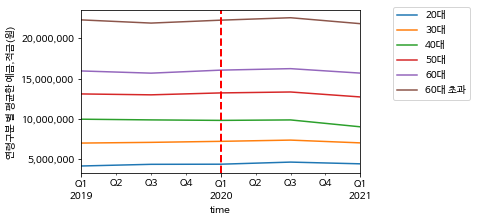

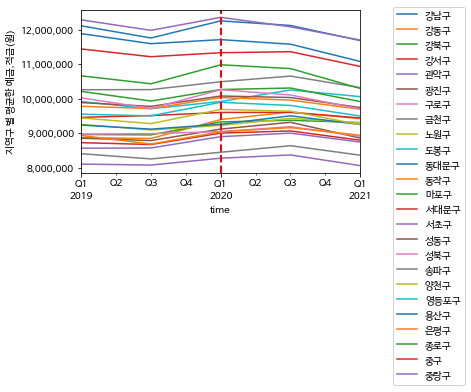

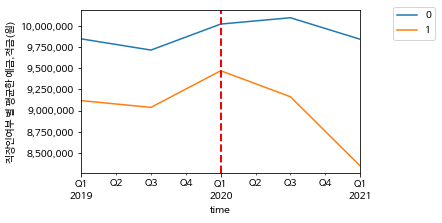

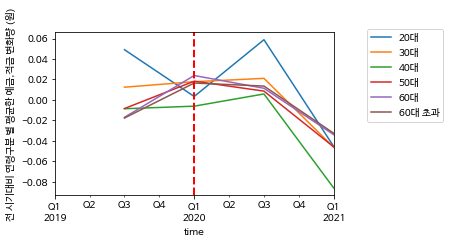

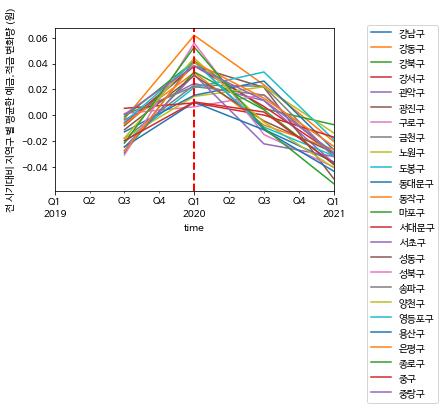

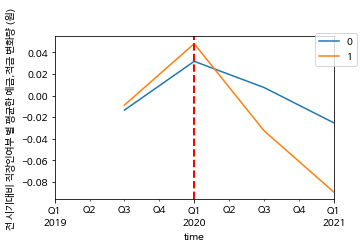

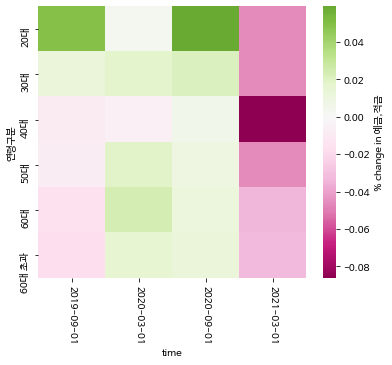

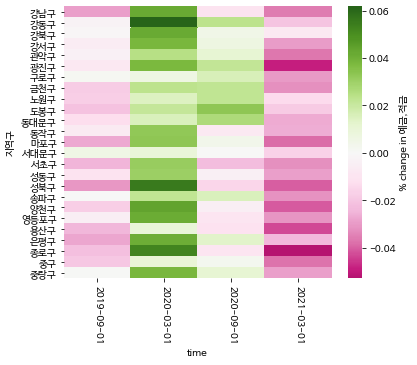

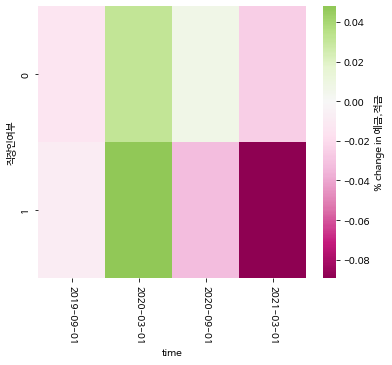

In [ ]:
list_of_categories = ['연령구분', '지역구', '직장인여부']
for cat in list_of_categories:
  data_detail_type = data_nans.groupby(['time',cat])['예금,적금'].agg('mean')
  ax1 = data_detail_type.unstack(cat, fill_value=0).plot(figsize=(5,3)).set_ylabel('{0} 별 평균한 예금,적금(원)'.format(cat))
  ax=plt.gca()
  ax.get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
  plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
  plt.legend(bbox_to_anchor=(1.1, 1.05))

for cat in list_of_categories:
  data_detail_type = data_nans.groupby(['time',cat])['예금,적금'].agg('mean').groupby([cat]).pct_change()
  ax1 = data_detail_type.unstack(cat, fill_value=0).plot(figsize=(5,3)).set_ylabel('전 시기대비 {0} 별 평균한 예금,적금 변화량 (원)'.format(cat))
  plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
  plt.legend(bbox_to_anchor=(1.1, 1.05))

for cat in list_of_categories:
  d = data_nans.groupby(['time',cat])['예금,적금'].agg('mean').groupby([cat]).pct_change()

  df = pd.DataFrame(d).reset_index().pivot_table(index=cat, columns="time", values='예금,적금')

  f, axes = plt.subplots(1, 1, figsize=(6,5))
  ax = sns.heatmap(df, cbar_kws={'label': '% change in 예금,적금'}, cmap="PiYG",center=0)

  ax.set_xticklabels(df.iloc[0].index.strftime('%Y-%m-%d'))
  plt.xticks(rotation=-90)

  plt.show()

In [ ]:
times= [201903, 201909, 202003, 202009, 202103]

appended_data_dong={}
for i, year in enumerate(times):
  dongmean예금=c[c['기준년월']==year ].groupby('행정구역코드')['예금,적금'].mean().reset_index()
  dongmean예금['행정구역코드']=dongmean예금['행정구역코드'].astype(str)
  appended_data_dong[year] =   dongmean예금

appended_data_gu={}
for i, year in enumerate(times):
  gumean예금=data[data['기준년월']==year ].groupby('지역구')['예금,적금'].mean().reset_index()
  gumean예금['지역구']=gumean예금['지역구'].astype(str)
  appended_data_gu[year] = gumean예금

447180.5068493151

### 구를 기준으로 평균한 예금/적금를 지도로 시각화

In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/skorea-municipalities-2018-geo.json'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/gumean예금/'

if not os.path.exists(directory):
  os.makedirs(directory)


for year, yearlydata in appended_data_gu.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('지역구', '예금,적금'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='구 평균 예금,적금',
                nan_fill_color = "White",
                threshold_scale=range(1800000, 6300000,640000),
                key_on='properties.name').add_to(map)
  folium.LayerControl().add_to(map)

  map.save(directory+'plot_gumean예금_{0}.html'.format(year))

### 동를 기준으로 평균한 예금/적금를 지도로 시각화

In [ ]:
list(range(200000, 10000001,1400000))

[200000, 1600000, 3000000, 4400000, 5800000, 7200000, 8600000, 10000000]

In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/HangJeongDong_ver20210401.geojson'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/연습'

if not os.path.exists(directory):
  os.makedirs(directory)

for year, yearlydata in appended_data_dong.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('행정구역코드', '예금,적금'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='동별 평균 예금,적금',
                nan_fill_color = "Grey",
                threshold_scale=list(range(200000, 10000001,1400000)),
                key_on='feature.properties.adm_cd').add_to(map)
  folium.LayerControl().add_to(map)

  map.save(directory+'plot_dongmean예금_{0}.html'.format(year))

## 신용대출

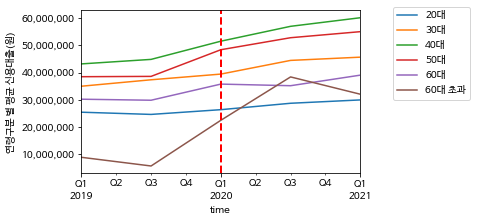

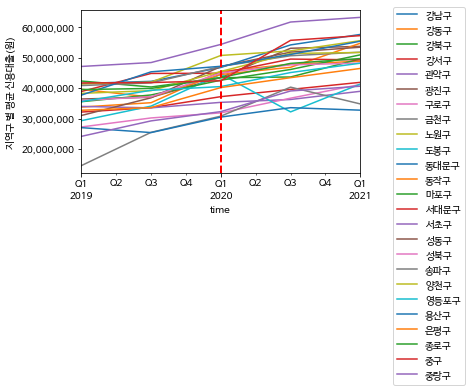

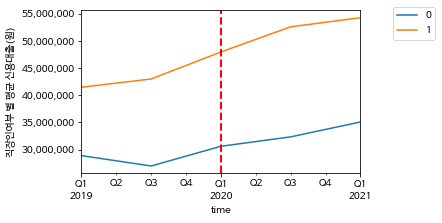

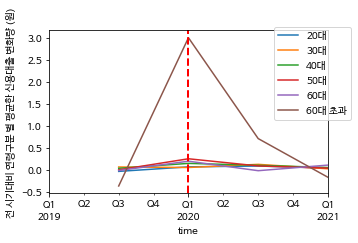

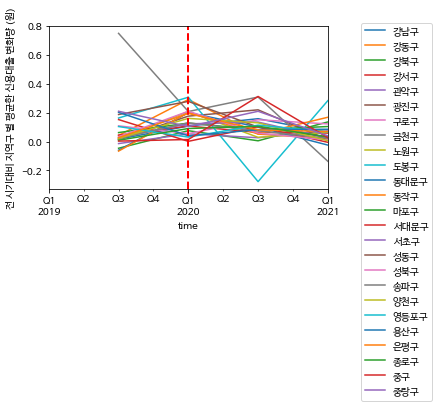

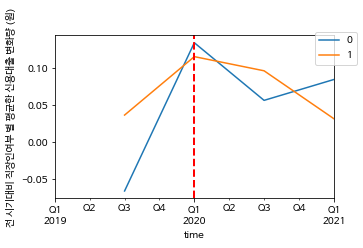

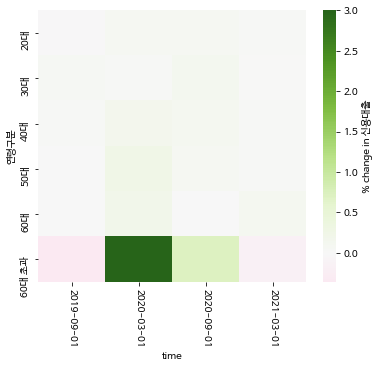

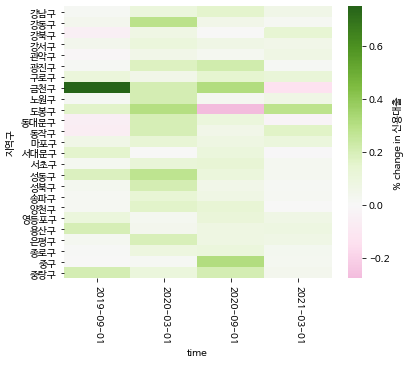

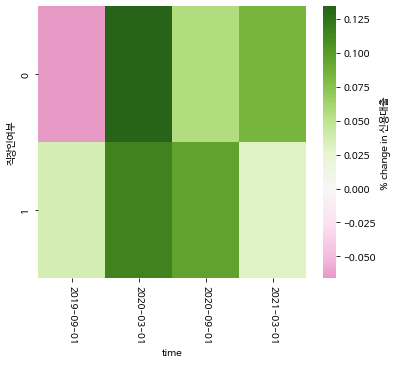

In [ ]:
list_of_categories = ['연령구분', '지역구', '직장인여부']
for cat in list_of_categories:
  data_detail_type = data_nans.groupby(['time',cat])['신용대출'].agg('mean')
  ax1 = data_detail_type.unstack(cat, fill_value=0).plot(figsize=(5,3)).set_ylabel('{0} 별 평균 신용대출(원)'.format(cat))
  plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
  ax=plt.gca()
  ax.get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
  plt.legend(bbox_to_anchor=(1.1, 1.05))

for cat in list_of_categories:
  data_detail_type = data_nans.groupby(['time',cat])['신용대출'].agg('mean').groupby([cat]).pct_change()
  ax1 = data_detail_type.unstack(cat, fill_value=0).plot(figsize=(5,3)).set_ylabel('전 시기대비 {0} 별 평균한 신용대출 변화량 (원)'.format(cat))
  plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
  plt.legend(bbox_to_anchor=(1.1, 1.05))

for cat in list_of_categories:
  d = data_nans.groupby(['time',cat])['신용대출'].agg('mean').groupby([cat]).pct_change()

  df = pd.DataFrame(d).reset_index().pivot_table(index=cat, columns="time", values='신용대출')

  f, axes = plt.subplots(1, 1, figsize=(6,5))
  ax = sns.heatmap(df, cbar_kws={'label': '% change in 신용대출'}, cmap="PiYG",center=0)

  ax.set_xticklabels(df.iloc[0].index.strftime('%Y-%m-%d'))
  plt.xticks(rotation=-90)

  plt.show()

### 동를 기준으로 평균한 신용대출 지도로 시각화

In [ ]:
times= [201903, 201909, 202003, 202009, 202103]

appended_data_dong={}
for i, year in enumerate(times):
  dongmean신용대출=c[c['기준년월']==year ].groupby('행정구역코드')['신용대출'].mean().reset_index()
  dongmean신용대출['행정구역코드']=dongmean신용대출['행정구역코드'].astype(str)
  appended_data_dong[year] =   dongmean신용대출


In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/HangJeongDong_ver20210401.geojson'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/dongmean신용대출/'

if not os.path.exists(directory):
  os.makedirs(directory)

for year, yearlydata in appended_data_dong.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('행정구역코드', '신용대출'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='동별 평균 신용대출',
                nan_fill_color = "Grey",
                threshold_scale=list(np.linspace(0, 4000000,7)),
                key_on='feature.properties.adm_cd').add_to(map)
  folium.LayerControl().add_to(map)

  map.save(directory+'plot_dongmean신용대출_{0}.html'.format(year))


## 신탁

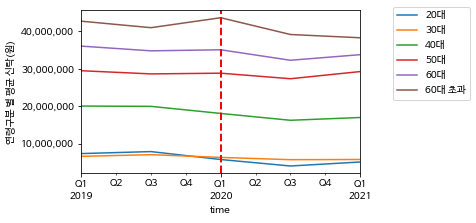

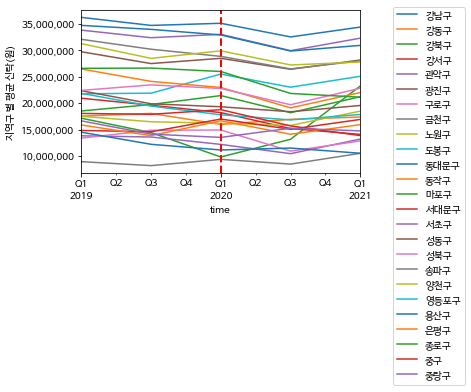

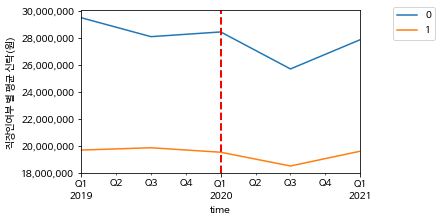

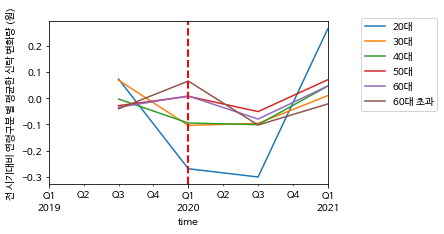

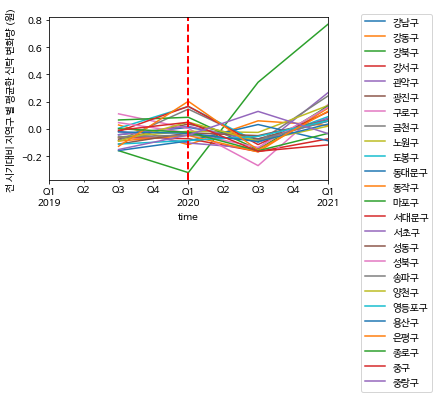

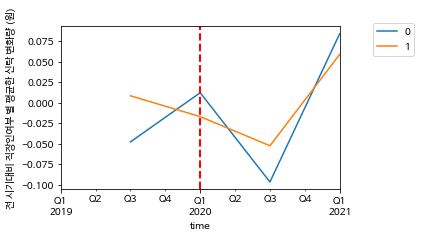

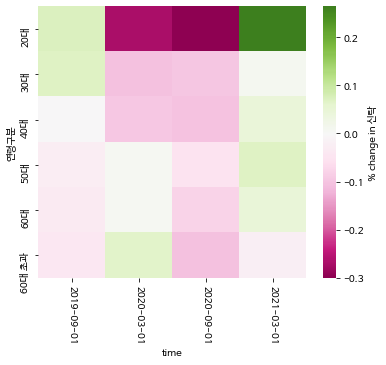

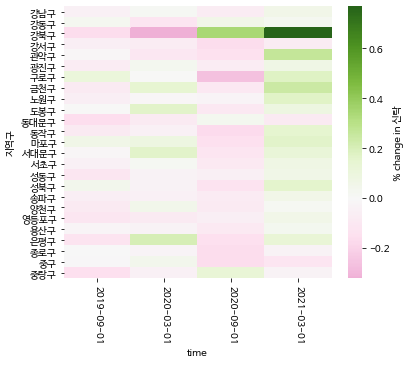

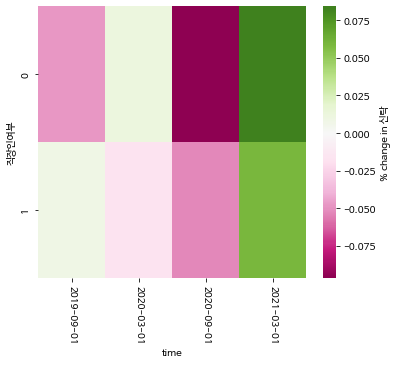

In [ ]:
list_of_categories = ['연령구분', '지역구', '직장인여부']
for cat in list_of_categories:
  data_detail_type = data_nans.groupby(['time',cat])['신탁'].agg('mean')
  ax1 = data_detail_type.unstack(cat, fill_value=0).plot(figsize=(5,3)).set_ylabel('{0} 별 평균 신탁(원)'.format(cat))
  plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
  ax=plt.gca()
  ax.get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
  plt.legend(bbox_to_anchor=(1.1, 1.05))

for cat in list_of_categories:
  data_detail_type = data_nans.groupby(['time',cat])['신탁'].agg('mean').groupby([cat]).pct_change()
  ax1 = data_detail_type.unstack(cat, fill_value=0).plot(figsize=(5,3)).set_ylabel('전 시기대비 {0} 별 평균한 신탁 변화량 (원)'.format(cat))
  plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
  plt.legend(bbox_to_anchor=(1.1, 1.05))

for cat in list_of_categories:
  d = data_nans.groupby(['time',cat])['신탁'].agg('mean').groupby([cat]).pct_change()

  df = pd.DataFrame(d).reset_index().pivot_table(index=cat, columns="time", values='신탁')

  f, axes = plt.subplots(1, 1, figsize=(6,5))
  ax = sns.heatmap(df, cbar_kws={'label': '% change in 신탁'}, cmap="PiYG",center=0)

  ax.set_xticklabels(df.iloc[0].index.strftime('%Y-%m-%d'))
  plt.xticks(rotation=-90)

  plt.show()

### 동를 기준으로 평균한 신탁 지도로 시각화

In [ ]:
times= [201903, 201909, 202003, 202009, 202103]

appended_data_dong={}
for i, year in enumerate(times):
  dongmean신탁=c[c['기준년월']==year ].groupby('행정구역코드')['신탁'].mean().reset_index()
  dongmean신탁['행정구역코드']=dongmean신탁['행정구역코드'].astype(str)
  appended_data_dong[year] =   dongmean신탁


In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/HangJeongDong_ver20210401.geojson'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/dongmean신탁/'

if not os.path.exists(directory):
  os.makedirs(directory)

for year, yearlydata in appended_data_dong.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('행정구역코드', '신탁'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='동별 평균 신탁',
                nan_fill_color = "Grey",
                # threshold_scale=list(np.linspace(0, 4000000,7)),
                key_on='feature.properties.adm_cd').add_to(map)
  folium.LayerControl().add_to(map)

  map.save(directory+'plot_dongmean신탁_{0}.html'.format(year))

## 수익증권

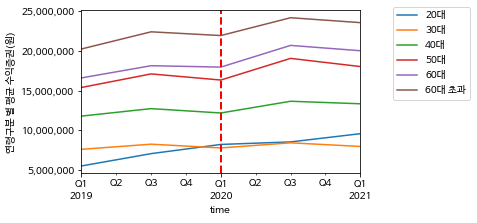

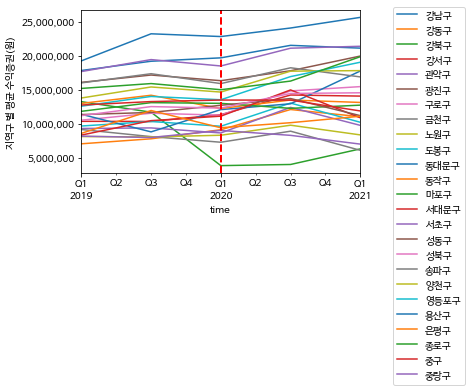

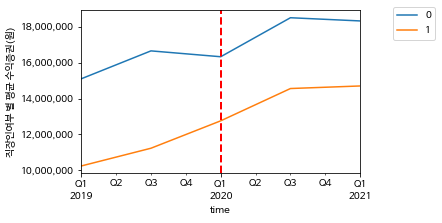

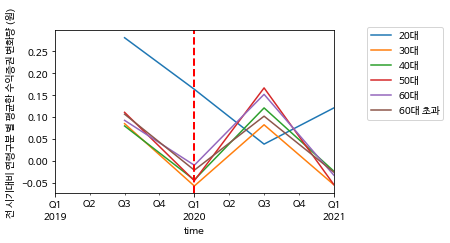

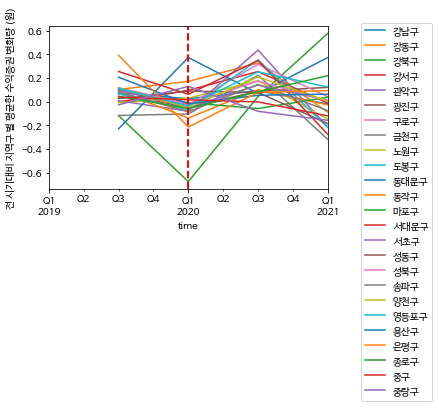

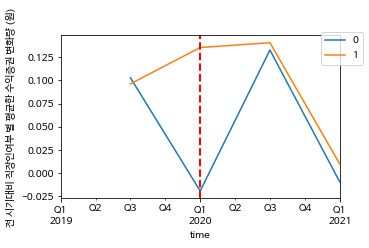

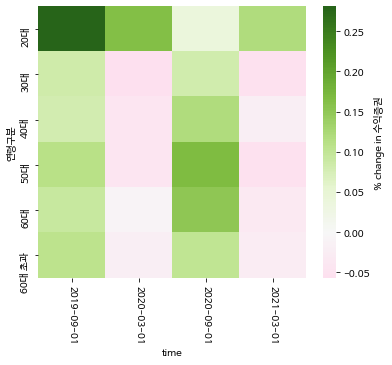

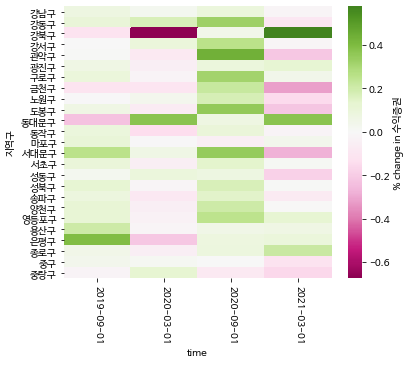

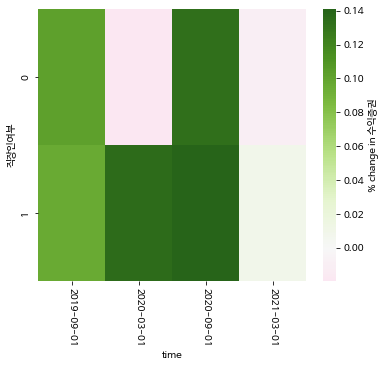

In [ ]:
list_of_categories = ['연령구분', '지역구', '직장인여부']
for cat in list_of_categories:
  data_detail_type = data_nans.groupby(['time',cat])['수익증권'].agg('mean')
  ax1 = data_detail_type.unstack(cat, fill_value=0).plot(figsize=(5,3)).set_ylabel('{0} 별 평균 수익증권(원)'.format(cat))
  plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
  ax=plt.gca()
  ax.get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
  plt.legend(bbox_to_anchor=(1.1, 1.05))

for cat in list_of_categories:
  data_detail_type = data_nans.groupby(['time',cat])['수익증권'].agg('mean').groupby([cat]).pct_change()
  ax1 = data_detail_type.unstack(cat, fill_value=0).plot(figsize=(5,3)).set_ylabel('전 시기대비 {0} 별 평균한 수익증권 변화량 (원)'.format(cat))
  plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
  plt.legend(bbox_to_anchor=(1.1, 1.05))

for cat in list_of_categories:
  d = data_nans.groupby(['time',cat])['수익증권'].agg('mean').groupby([cat]).pct_change()

  df = pd.DataFrame(d).reset_index().pivot_table(index=cat, columns="time", values='수익증권')

  f, axes = plt.subplots(1, 1, figsize=(6,5))
  ax = sns.heatmap(df, cbar_kws={'label': '% change in 수익증권'}, cmap="PiYG",center=0)

  ax.set_xticklabels(df.iloc[0].index.strftime('%Y-%m-%d'))
  plt.xticks(rotation=-90)

  plt.show()

### 동를 기준으로 평균한 수익증권 지도로 시각화

In [ ]:
times= [201903, 201909, 202003, 202009, 202103]

appended_data_dong={}
for i, year in enumerate(times):
  dongmean수익증권=c[c['기준년월']==year ].groupby('행정구역코드')['수익증권'].mean().reset_index()
  dongmean수익증권['행정구역코드']=dongmean수익증권['행정구역코드'].astype(str)
  appended_data_dong[year] =   dongmean수익증권

In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/HangJeongDong_ver20210401.geojson'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/dongmean수익증권/'

if not os.path.exists(directory):
  os.makedirs(directory)

for year, yearlydata in appended_data_dong.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('행정구역코드', '수익증권'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='동별 평균 수익증권',
                nan_fill_color = "Grey",
                # threshold_scale=list(np.linspace(0, 4000000,7)),
                key_on='feature.properties.adm_cd').add_to(map)
  folium.LayerControl().add_to(map)

  map.save(directory+'plot_dongmean수익증권_{0}.html'.format(year))

## 담보대출

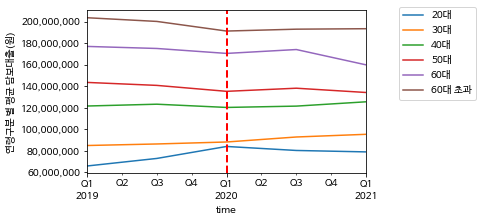

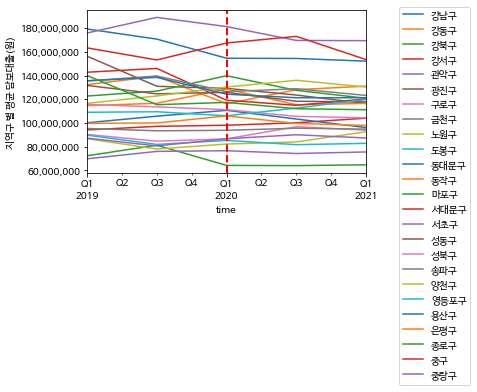

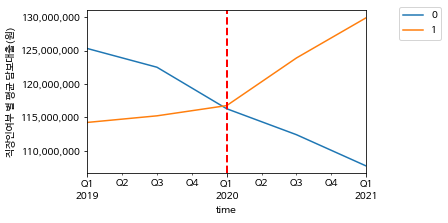

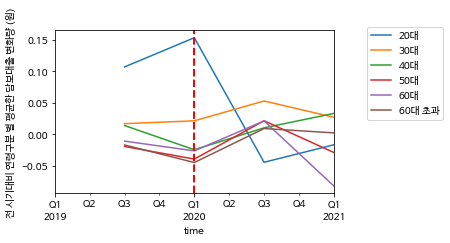

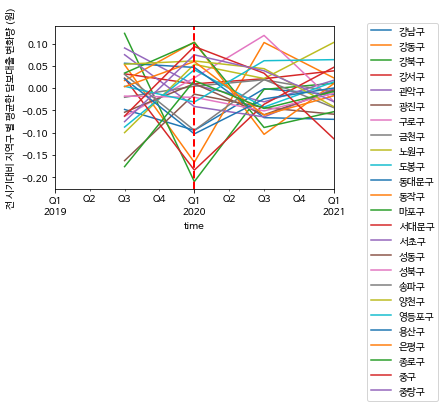

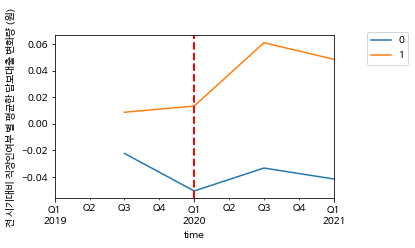

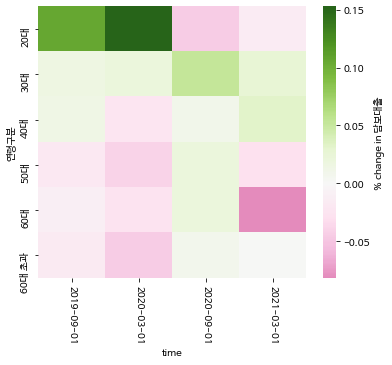

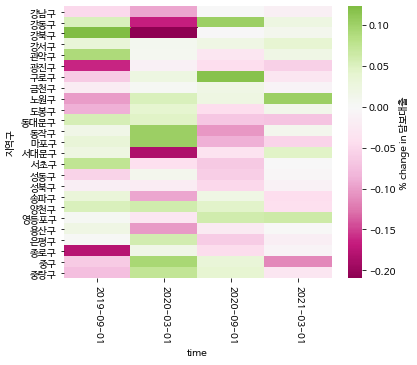

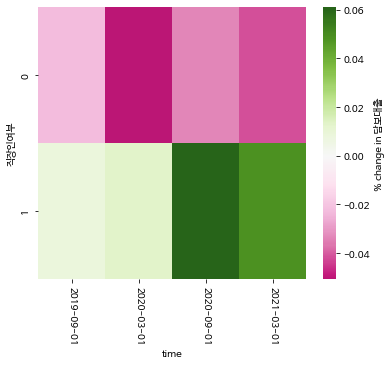

In [ ]:
list_of_categories = ['연령구분', '지역구', '직장인여부']
for cat in list_of_categories:
  data_detail_type = data_nans.groupby(['time',cat])['담보대출'].agg('mean')
  ax1 = data_detail_type.unstack(cat, fill_value=0).plot(figsize=(5,3)).set_ylabel('{0} 별 평균 담보대출(원)'.format(cat))
  plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
  ax=plt.gca()
  ax.get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
  plt.legend(bbox_to_anchor=(1.1, 1.05))

for cat in list_of_categories:
  data_detail_type = data_nans.groupby(['time',cat])['담보대출'].agg('mean').groupby([cat]).pct_change()
  ax1 = data_detail_type.unstack(cat, fill_value=0).plot(figsize=(5,3)).set_ylabel('전 시기대비 {0} 별 평균한 담보대출 변화량 (원)'.format(cat))
  plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
  plt.legend(bbox_to_anchor=(1.1, 1.05))

for cat in list_of_categories:
  d = data_nans.groupby(['time',cat])['담보대출'].agg('mean').groupby([cat]).pct_change()

  df = pd.DataFrame(d).reset_index().pivot_table(index=cat, columns="time", values='담보대출')

  f, axes = plt.subplots(1, 1, figsize=(6,5))
  ax = sns.heatmap(df, cbar_kws={'label': '% change in 담보대출'}, cmap="PiYG",center=0)

  ax.set_xticklabels(df.iloc[0].index.strftime('%Y-%m-%d'))
  plt.xticks(rotation=-90)

  plt.show()

동를 기준으로 평균한 담보대출 지도로 시각화

In [ ]:
times= [201903, 201909, 202003, 202009, 202103]

appended_data_dong={}
for i, year in enumerate(times):
  dongmean담보대출=dongmean[dongmean['기준년월']==year ].groupby('행정구역코드')['담보대출'].mean().reset_index()
  dongmean담보대출['행정구역코드']=dongmean담보대출['행정구역코드'].astype(str)
  appended_data_dong[year] =   dongmean담보대출

In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/HangJeongDong_ver20210401.geojson'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/dongmean담보대출/'

if not os.path.exists(directory):
  os.makedirs(directory)

for year, yearlydata in appended_data_dong.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('행정구역코드', '담보대출'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='동별 평균 담보대출',
                nan_fill_color = "Grey",
                # threshold_scale=list(np.linspace(0, 4000000,7)),
                key_on='feature.properties.adm_cd').add_to(map)
  folium.LayerControl().add_to(map)

  map.save(directory+'plot_dongmean담보대출_{0}.html'.format(year))

## 주택대출

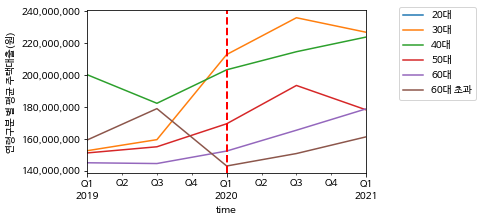

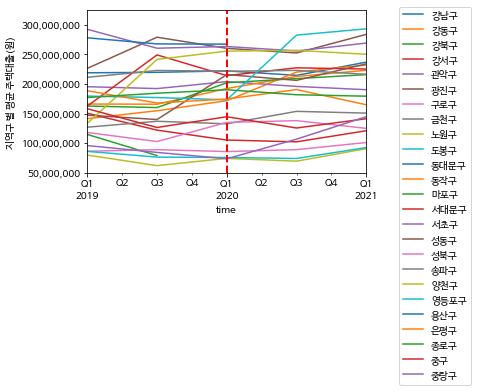

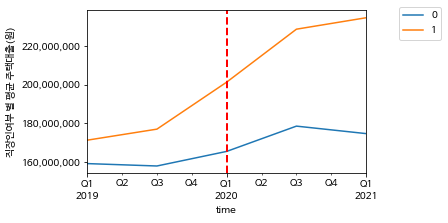

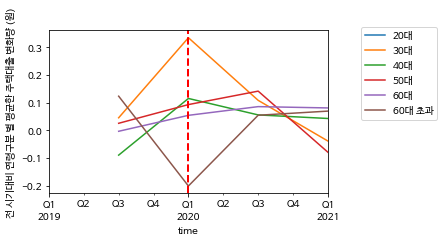

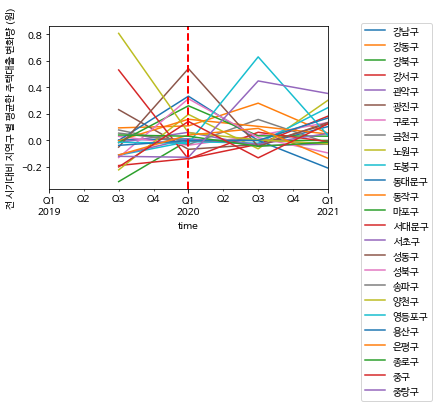

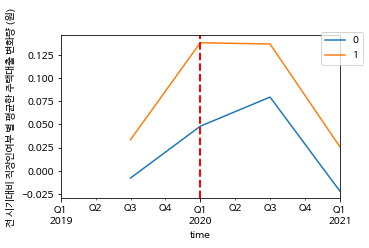

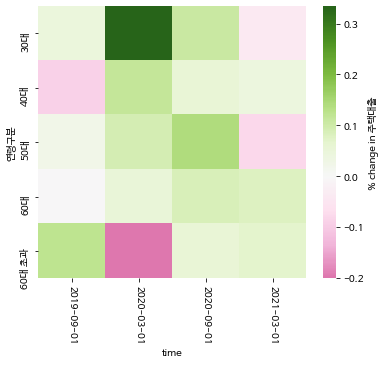

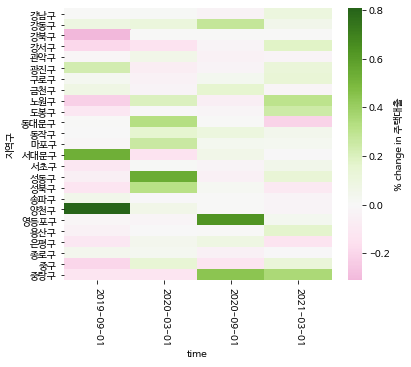

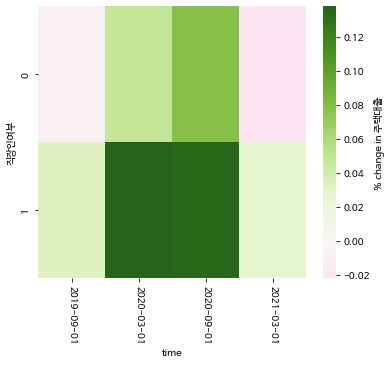

In [ ]:
list_of_categories = ['연령구분', '지역구', '직장인여부']
for cat in list_of_categories:
  data_detail_type = data_nans.groupby(['time',cat])['주택대출'].agg('mean')
  ax1 = data_detail_type.unstack(cat, fill_value=0).plot(figsize=(5,3)).set_ylabel('{0} 별 평균 주택대출(원)'.format(cat))
  plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
  ax=plt.gca()
  ax.get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
  plt.legend(bbox_to_anchor=(1.1, 1.05))

for cat in list_of_categories:
  data_detail_type = data_nans.groupby(['time',cat])['주택대출'].agg('mean').groupby([cat]).pct_change()
  ax1 = data_detail_type.unstack(cat, fill_value=0).plot(figsize=(5,3)).set_ylabel('전 시기대비 {0} 별 평균한 주택대출 변화량 (원)'.format(cat))
  plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
  plt.legend(bbox_to_anchor=(1.1, 1.05))

for cat in list_of_categories:
  d = data_nans.groupby(['time',cat])['주택대출'].agg('mean').groupby([cat]).pct_change()

  df = pd.DataFrame(d).reset_index().pivot_table(index=cat, columns="time", values='주택대출')

  f, axes = plt.subplots(1, 1, figsize=(6,5))
  ax = sns.heatmap(df, cbar_kws={'label': '% change in 주택대출'}, cmap="PiYG",center=0)

  ax.set_xticklabels(df.iloc[0].index.strftime('%Y-%m-%d'))
  plt.xticks(rotation=-90)

  plt.show()

동를 기준으로 평균한 주택대출 지도로 시각화

In [ ]:
times= [201903, 201909, 202003, 202009, 202103]

appended_data_dong={}
for i, year in enumerate(times):
  dongmean주택대출=dongmean[dongmean['기준년월']==year ].groupby('행정구역코드')['주택대출'].mean().reset_index()
  dongmean주택대출['행정구역코드']=dongmean주택대출['행정구역코드'].astype(str)
  appended_data_dong[year] =   dongmean주택대출

In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/HangJeongDong_ver20210401.geojson'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/dongmean주택대출/'

if not os.path.exists(directory):
  os.makedirs(directory)

for year, yearlydata in appended_data_dong.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('행정구역코드', '주택대출'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='동별 평균 주택대출',
                nan_fill_color = "Grey",
                # threshold_scale=list(np.linspace(0, 4000000,7)),
                key_on='feature.properties.adm_cd').add_to(map)
  folium.LayerControl().add_to(map)

  map.save(directory+'plot_dongmean주택대출_{0}.html'.format(year))

## 전세대출

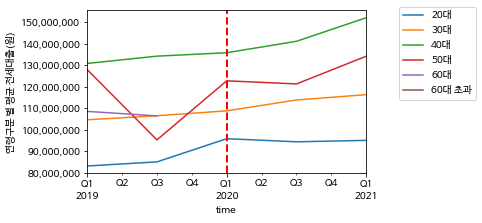

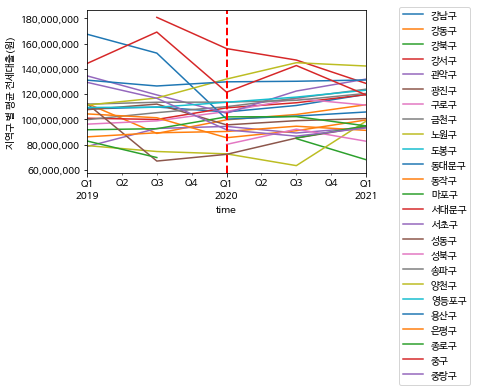

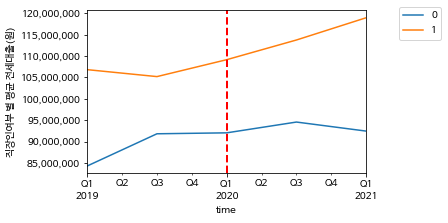

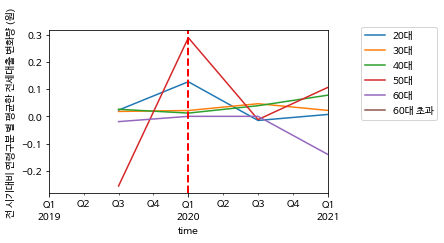

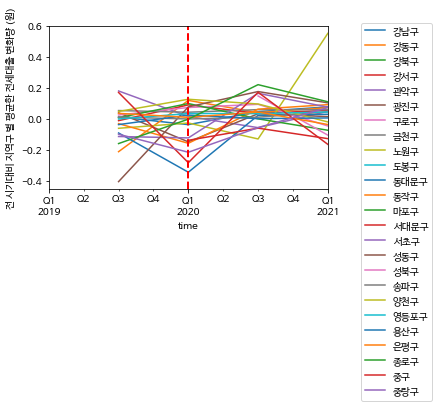

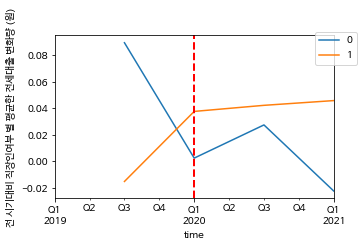

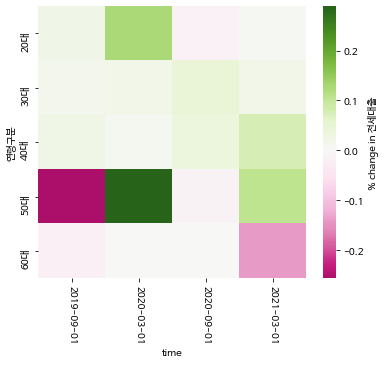

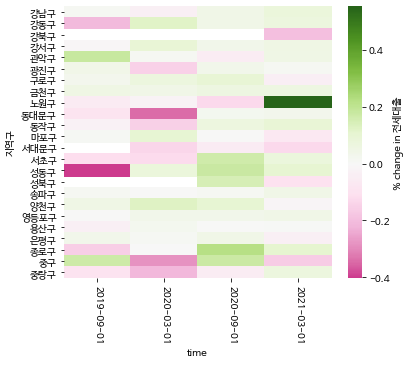

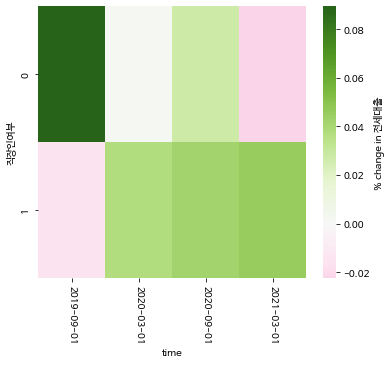

In [ ]:
list_of_categories = ['연령구분', '지역구', '직장인여부']
for cat in list_of_categories:
  data_detail_type = data_nans.groupby(['time',cat])['전세대출'].agg('mean')
  ax1 = data_detail_type.unstack(cat, fill_value=0).plot(figsize=(5,3)).set_ylabel('{0} 별 평균 전세대출(원)'.format(cat))
  plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
  ax=plt.gca()
  ax.get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
  plt.legend(bbox_to_anchor=(1.1, 1.05))

for cat in list_of_categories:
  data_detail_type = data_nans.groupby(['time',cat])['전세대출'].agg('mean').groupby([cat]).pct_change()
  ax1 = data_detail_type.unstack(cat, fill_value=0).plot(figsize=(5,3)).set_ylabel('전 시기대비 {0} 별 평균한 전세대출 변화량 (원)'.format(cat))
  plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
  plt.legend(bbox_to_anchor=(1.1, 1.05))
  

for cat in list_of_categories:
  d = data_nans.groupby(['time',cat])['전세대출'].agg('mean').groupby([cat]).pct_change()

  df = pd.DataFrame(d).reset_index().pivot_table(index=cat, columns="time", values='전세대출')

  f, axes = plt.subplots(1, 1, figsize=(6,5))
  ax = sns.heatmap(df, cbar_kws={'label': '% change in 전세대출'}, cmap="PiYG",center=0)

  ax.set_xticklabels(df.iloc[0].index.strftime('%Y-%m-%d'))
  plt.xticks(rotation=-90)

  plt.show()

# Time Slider Functions

In [ ]:
 def color_scale(meandata, column):
  """

  Input: dongmean data , column
  Output: color data with only that column in dongmean data, and the colormap (cmap)

  Define a color map in terms of each dong’s column mean for each year, then map the colors to a predefined color map. 

  To create the colormap, we calculate the maximum and minimum values over all the timeseries. 
  Then, convert datetime to U10 with pandas.DatetimeIndex() and astype()
  reference: https://jingwen-z.github.io/how-to-draw-a-variety-of-maps-with-folium-in-python/
  """
  data = meandata[['행정구역코드', 'time', column]].dropna()
 # data[column] = data[column].fillna(0)
  max_colour = max(data[column])
  min_colour = min(data[column])
  q3_colour = data[column].quantile(0.75)
  q2_colour = data[column].quantile(0.5)
  q1_colour = data[column].quantile(0.25)
  cmap = LinearColormap(
                      #colors=['gray', 'beige', 'yellow', 'orange', 'red', 'purple'], 
                      colors=['gray', 'yellow', 'red'], 
                      index=[0, min_colour,  max_colour],
                      vmin = min_colour, vmax = max_colour,
                      #scale_width = 800, scale_height=20
                      ).to_step(6)

  #cmap = linear.YlOrRd_09.scale(min_colour, max_colour) 
  # cmap = LinearColormap(['yellow','red'], vmin = min_colour, vmax = max_colour)
  
  data['colour'] = data[column].map(cmap)

  data['date_sec'] = pd.to_datetime(data['time']).astype(int) / 10**9
  data['date_sec'] = data['date_sec'].astype(int).astype(str)

  return data, cmap
  print(column, 'min_colour={} max_colour={}'.format(min_colour, max_colour))

In [ ]:
# style_dictionary function required for time slider
def style_dictionary(meandata):

  """
  Input: dongmean_polygon
  Output: style_dict

  Note that dongmean has 2130 rows while dongmean_polygon 21302115. This is because there are some 법정동 in our data that is not in the geojson. 
  since the geopandas df (행정구역_gdf) was merged on dongmean_polygon, and the index must match for the style dictionary, use dongmean_polygon.

  Creating the style dictionary
  In the color map, Color is set, but opacity is not set here, so its just 0.7. If opacity needs to be set, 
  Do the same approach as color in the colorm_scale() function: calculate the max/min of the opacity column, so that we can map that column into a range [0,1]
  """
  구역_list = meandata['행정구역코드'].unique().tolist()
  구역_idx = range(len(구역_list))

  style_dict = {}
  for i in 구역_idx:
      구역 = 구역_list[i]
      result = meandata[meandata['행정구역코드'] == 구역]
      inner_dict = {}
      for _, r in result.iterrows():
          inner_dict[r['date_sec']] = {'color': r['colour'], 'opacity': 0.7}
      style_dict[str(i)] = inner_dict
  
  return style_dict

In [ ]:
# function to make Time slider maps
def Time_slider_all(mapdata, meandata, column): 

  #column=str(column)
  directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/dongmean{0}/'.format(column)

  if not os.path.exists(directory):
    os.makedirs(directory)

  
  data, cmap = color_scale(meandata, column)
  style_dict = style_dictionary(data)

  map = folium.Map(location=[37.5502, 126.982], zoom_start=11, max_bounds=True)

  g = TimeSliderChoropleth(
      mapdata,
      styledict=style_dict, overlay = True
  ).add_to(map)

  map.add_child(cmap)

  cmap.caption = '평균 {0}'.format(column) + '____________'+  'Grey: No Data ; Yellow: Minimum'

  map.add_child(folium.map.LayerControl())

  map.save(directory+'plot_dongmean_timeslider_{0}'.format(column))

  display(map)

In [ ]:
# Execute function
numcol_list = ['급여','가맹점매출', '연금', '총지출', '총수신', '예금,적금', '신탁', '수익증권', '신용대출', '담보대출','주택대출', '전세대출']

for column_name in numcol_list:
  Time_slider_all(행정구역_gdf, dongmean_polygon, column_name)

Output hidden; open in https://colab.research.google.com to view.

# 직장인여부로 분류해서 분석

## 직장인

Betweeen 직장인 and not 직장인, 급여 is obviously different.
총지출, 총수신 are also very different dependong on job status.

For 직장인, most 가맹점매출 is 0.

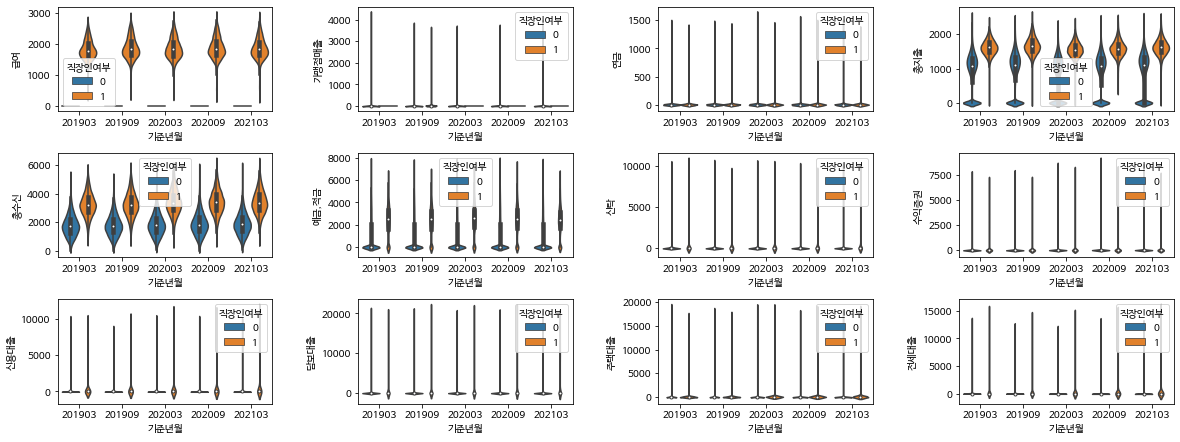

In [ ]:
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

count=1
for column_name in numcol_list:
  plt.subplot(4,4,count)
  plt.ylabel(column_name)
  sns.violinplot(data['기준년월'], np.sqrt(data[column_name]), data=data, hue='직장인여부')
  count+=1
plt.show()

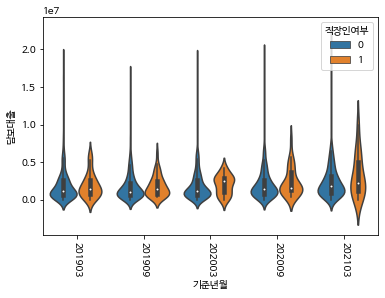

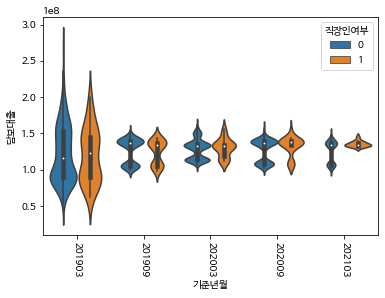

In [ ]:
ax=sns.violinplot(dongmean_map['기준년월'], dongmean_map['담보대출'], data=data, hue='직장인여부', height=8.27, aspect=11.7/8.27)
plt.xticks(rotation=-90)
plt.show()

ax=sns.violinplot(dongmean_graph['기준년월'], dongmean_graph['담보대출'], data=data, hue='직장인여부', height=8.27, aspect=11.7/8.27)
plt.xticks(rotation=-90)
plt.show()

In [ ]:
직장인 = data[data['직장인여부']=='1']
not_직장인 = data[data['직장인여부']=='0']

In [ ]:
# function to make Time slider maps
def Time_slider_subset(mapdata, meandata, column, 직장인): 

  #column=str(column)
  
  directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/dongmean{0}/'.format(column)

  if not os.path.exists(directory):
    os.makedirs(directory)

  
  data, cmap = color_scale(meandata, column)
  style_dict = style_dictionary(data)

  map = folium.Map(location=[37.5502, 126.982], zoom_start=11, max_bounds=True)

  g = TimeSliderChoropleth(
      mapdata,
      styledict=style_dict, overlay = True
  ).add_to(map)

  map.add_child(cmap)

  cmap.caption = '평균 {0}'.format(column)

  map.add_child(folium.map.LayerControl())
  if bool(직장인):
    map.save(directory+'직장인dongmean_timeslider_{0}'.format(column))
  else:
    map.save(directory+'not직장인dongmean_timeslider_{0}'.format(column))
  

  display(map)

In [ ]:
# Execute group mean function

dongmean = mean_groupby_dong(path, 직장인)
행정구역_gdf, dongmean_polygon = map_data_preprocessing(path, dongmean)

# Execute mapping functions
numcol_list = ['급여', '연금', '총지출', '총수신', '예금,적금', '신탁', '수익증권', '신용대출', '담보대출','주택대출', '전세대출']

for column_name in numcol_list:
  Time_slider_subset(행정구역_gdf, dongmean_polygon, column_name, 직장인=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
dongmean

Empty DataFrame
Columns: [기준년월, time, 행정구역코드, 급여, 가맹점매출, 연금, 총지출, 총수신, 예금,적금, 신탁, 수익증권, 신용대출, 담보대출, 주택대출, 전세대출, 법정동코드]
Index: []

## Not 직장인

In [ ]:
# Execute group mean function

dongmean = mean_groupby_dong(path, not_직장인)
행정구역_gdf, dongmean_polygon = map_data_preprocessing(path, dongmean)

# Execute mapping functions
numcol_list = ['가맹점매출','연금', '총지출', '총수신', '예금,적금', '신탁', '수익증권', '신용대출', '담보대출','주택대출', '전세대출']

for column_name in numcol_list:
  Time_slider_subset(행정구역_gdf, dongmean_polygon, column_name, 직장인=False)

Output hidden; open in https://colab.research.google.com to view.

# etc code

In [ ]:
datetime_index = pd.DatetimeIndex(dongmean['time'])
dt_index_epochs = datetime_index.astype(int) // 10**9
dt_index = dt_index_epochs.astype('U10')
dt_index


styledata = {}
n_periods = len(dt_index)
n_sample = len(dt_index)
for i, v in dong_shape.iterrows():
    df = pd.DataFrame(
        {'color': np.array(dongmean['급여']),
          'opacity': 0*np.random.normal(size=n_periods)},
         index=dt_index)
    df.sample(n_sample, replace=False).sort_index()
    styledata[i] = df


max_color = max(dongmean['급여'])
min_color = min(dongmean['급여'])
max_opacity, min_opacity = 1, 1

cmap = linear.YlGnBu_09.scale(min_color, max_color)

def norm(x):
    return (x - x.min()) / (x.max() - x.min())

for i, data in styledata.items():
    data['color'] = data['color'].map(cmap)
    data['opacity'] = 1

styledict = {
    str(nbh): data.reset_index().to_dict(orient="index") for nbh, data in styledata.items()
}

In [ ]:
dongmean_polygon_급여 = dongmean_map[['행정구역코드', 'time', '급여']].dropna()
#dongmean_polygon_급여.dropna(how='all')
max_colour = max(dongmean_polygon_급여['급여'])
q3_colour = dongmean_polygon_급여['급여'].quantile(0.75)
q2_colour = dongmean_polygon_급여['급여'].quantile(0.5)
q1_colour = dongmean_polygon_급여['급여'].quantile(0.25)
min_colour = min(dongmean_polygon_급여['급여'])
cmap = LinearColormap(colors=['gray', 'beige', 'yellow', 'orange', 'red', 'purple'], 
                      index=[0, min_colour, q1_colour, q2_colour, q3_colour, max_colour],
                      vmin = min_colour, vmax = max_colour)
dongmean_polygon_급여['colour'] = dongmean_polygon_급여['급여'].map(cmap)

dongmean_polygon_급여['date_sec'] = pd.to_datetime(dongmean_polygon_급여['time']).astype(int) / 10**9
dongmean_polygon_급여['date_sec'] = dongmean_polygon_급여['date_sec'].astype(int).astype(str)

In [ ]:
dongmean_polygon_급여.isnull().sum()

행정구역코드      0
time        0
급여          0
colour      0
date_sec    0
dtype: int64

In [ ]:
dongmean_polygon_급여

행정구역코드       time            급여     colour    date_sec
0     1101053 2019-03-01  3.874858e+06  #ff5f00ff  1551398400
1     1101054 2019-03-01  3.804061e+06  #ff6500ff  1551398400
2     1101055 2019-03-01  3.284998e+06  #ff8f00ff  1551398400
3     1101056 2019-03-01  3.291408e+06  #ff8e00ff  1551398400
4     1101057 2019-03-01  3.324663e+06  #ff8b00ff  1551398400
...       ...        ...           ...        ...         ...
2125  1125073 2021-03-01  3.163298e+06  #ff9800ff  1614556800
2126  1125074 2021-03-01  3.159667e+06  #ff9900ff  1614556800
2127  1125075 2021-03-01  3.236637e+06  #ff9200ff  1614556800
2128  1125076 2021-03-01  3.253652e+06  #ff9100ff  1614556800
2129  1125077 2021-03-01  3.253652e+06  #ff9100ff  1614556800

[2129 rows x 5 columns]

In [ ]:
if dongmean['급여'].isnull().sum()

.dropna(axis='columns')


In [ ]:
cmap

In [ ]:
구역_list = dongmean_polygon_급여['행정구역코드'].unique().tolist()
구역_idx = range(len(구역_list))

style_dict = {}
for i in 구역_idx:
    구역 = 구역_list[i]
    result = dongmean_polygon_급여[dongmean_polygon_급여['행정구역코드'] == 구역]
    inner_dict = {}
    for _, r in result.iterrows():
        inner_dict[r['date_sec']] = {'color': r['colour'], 'opacity': 0.7}
    style_dict[str(i)] = inner_dict

In [ ]:
directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/연습/'

if not os.path.exists(directory):
  os.makedirs(directory)


map = folium.Map(location=[37.5502, 126.982], zoom_start=11, max_bounds=True)

g = TimeSliderChoropleth(
    행정구역_gdf,
    styledict=style_dict, overlay = True
).add_to(map)

map.add_child(cmap)
cmap.caption = "평균 급여"

map.save(directory+'plot_dongmean급여_timeslider_2')

In [ ]:
display(map)

In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/HangJeongDong_ver20210401.geojson'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

times= [201903, 201909, 202003, 202009, 202103]
list_columns = ['가맹점매출',	'연금',	'총지출',	'총수신',	'예금,적금',	'신탁',	'수익증권',	'신용대출',	'담보대출',	'주택대출',	'전세대출'	]
for column in list_columns:

  appended_data_dong={}
  for i, year in enumerate(times):
    dongmean = c[c['기준년월']==year ].groupby('행정구역코드')[column].mean().reset_index()
    dongmean['행정구역코드'] = dongmean['행정구역코드'].astype(str)
    appended_data_dong[year] =  dongmean

  appended_data_gu={}
  for i, year in enumerate(times):
    gumean = data[data['기준년월']==year ].groupby('지역구')[column].mean().reset_index()
    gumean['지역구'] = gumean['지역구'].astype(str)
    appended_data_gu[year] = gumean


    # GU 

    directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/gumean{0}/'.format(column)

    if not os.path.exists(directory):
      os.makedirs(directory)


    for year, yearlydata in appended_data_gu.items():
      map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
      folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('지역구', column),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='구 평균 평균 {0}'.format(column),
                nan_fill_color = "White",
                threshold_scale=range(1800000, 6300000,640000),
                key_on='properties.name').add_to(map)
      folium.LayerControl().add_to(map)

      map.save(directory+'plot_gumean_%s_%d.html' %(column, year))

    # DONG
    directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/shinhan/dongmean{0}/'.format(column)

    if not os.path.exists(directory):
      os.makedirs(directory)

    for year, yearlydata in appended_data_dong.items():
      map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
      folium.Choropleth(geo_data=geo_str,
                    data=yearlydata,
                    columns=('행정구역코드', column),
                    fill_color='BuPu',
                    fill_opacity=0.8,
                    line_opacity=0.2,
                    legend_name='동별 평균 {0}'.format(column),
                    nan_fill_color = "Grey",
                    threshold_scale=list(range(200000, 10000001,1400000)),
                    key_on='feature.properties.adm_cd').add_to(map)
      folium.LayerControl().add_to(map)

      map.save(directory+'plot_dongmean_%s_%d.html' %(column, year))


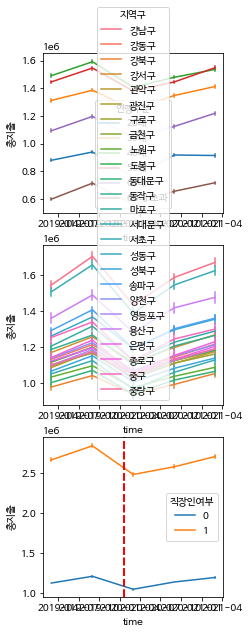

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10), sharey=False)
#fig.subplots_adjust(hspace=1)
list_of_categories = ['연령구분', '지역구', '직장인여부']
for i, cat in enumerate(list_of_categories):
  data_detail_type = data_means.groupby(['time',cat])['총지출'].mean().reset_index()
  # ax1 = data_detail_type.unstack(cat, fill_value=0).plot(figsize=(10,5)).set_ylabel('{0} 별 총 총지출 (원)'.format(i))
  sns.lineplot(ax=axes[i], data=data, x="time", y="총지출", hue=cat, err_style="bars", ci=95)
  plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
  #plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3))
  #plt.legend(bbox_to_anchor=(1.1, 1.05))
fig.subplots_adjust(right=0.25)
plt.show()